# fit1 の実験ノート　2022.0318

In [9]:
import sys,os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import numpy as np
import matplotlib.pyplot as plt
import cv2
import wandb
import optuna
# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial,lambdify,poly
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')
from statistics import mean
import datetime
import time
datetime.datetime.now()

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/MyDrive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdexper as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

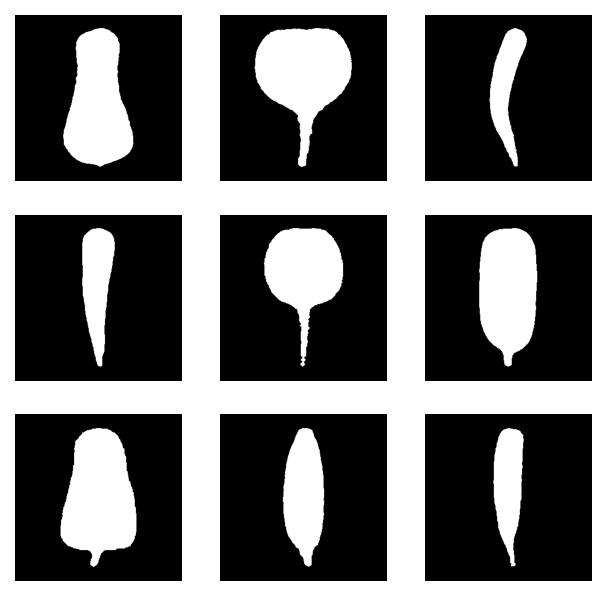

In [10]:
NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト
#imgs = collectimages(NSilF)       # シルエット画像のリスト
plt.figure(figsize=(5,5),dpi=150)
for i in range(9):
  rd.plotimg(imgs[i],330+i+1)
  #plotimg(imgs[i],330+i+1)


In [ ]:
import time

def meanerr(func, ts, Samples):
  sps = Samples
  fx, fy = func
  t = symbols('t')
  nfx, nfy = lambdify(t, fx, "numpy"), lambdify(t, fy, "numpy")
  onps = [[nfx(ts[i]), nfy(ts[i])] for i in range(len(ts))]
  return mean([np.sqrt((sps[i][0]-onps[i][0])**2+(sps[i][1]-onps[i][1])**2) for i in range(len(sps))])

def check0N(imgnum,Nsamples=65,Nfrom=5,Nto=20,err_th=0.65,withFig=True):
    results = {}
    for N in range(Nfrom,Nto+1):
      print(N,end='')
      start = time.process_time()
      img = imgs[imgnum]
      conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
      Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')
      bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
      cps, func = bez.fit0(tpara=[])
      etime = time.process_time() - start
      odds = rd.isOverFitting(func,bez.ts,conAll,tover=0.1,tunder=-0.1)
      err = meanerr(func,bez.ts,Samples)
      results[str(N)] = (odds,err,etime)
      if err < err_th:
        break
    print("\nN= {}  err = {}   etime = {}".format(N,err,etime))
    if withFig:
      rd.drawBez(imgs[imgnum],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return results

In [29]:
def check1N(imgnum,Nsamples=65,Nfrom=5,Nto=20,err_th=0.65,withFig=True):
    results = {}
    for N in range(Nfrom,Nto+1):
      print(N,end='')
      start = time.process_time()
      img = imgs[imgnum]
      conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
      Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')
      bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
      cps, func, err = bez.fit1(maxTry=3000, withErr=True, withEC=False, tpara=[], pat=300, err_th=err_th, threstune=1.0,scatter=False, moption=True)
      etime = time.process_time() - start
      odds = rd.isOverFitting(func,bez.ts,conAll,tover=0.1,tunder=-0.1)
      results[str(N)] = (odds,err,etime)
      if err < err_th and len(odds)==0:
        break
    print("\nN= {}  err = {}   etime = {}".format(N,err,etime))
    if withFig:
      rd.drawBez(imgs[imgnum],stt=0.0,end=1.0,bezL=func,cntL=Samples)
    return results

# check1N(imgnum, Samples, Nfrom, Nto, err_th, withFig)
imgnum: 処理象画像の番号  
Samples: 標本点の数  
Nfrom,Nto:  近似次数をNfrom から始めてNtoまで試す  
withFig: True なら結果が図示する  

(補足)誤差要求が満たされていてもオーバフィッティングが１ヶ所でも検出されれば停止せず処理を継続する

10...........................
CP 5.0, steps:26, etime: 42.25000 err: 4.9701682689
...................................................
CP 2.0, steps:77, etime: 120.39062 err: 1.9994488274
......................
..........................
CP 1.0, steps:125, etime: 193.78125 err: 0.9919268352
.........................................................
CP 0.65, steps:182, etime: 280.89062 err: 0.6497719994
.................
....................................................................................................
......................................................E


N= 10  err = 0.4999798339373072   etime = 541.5
Wall time: 9min 1s


{'10': (array([], dtype=int64), 0.4999798339373072, 541.5)}

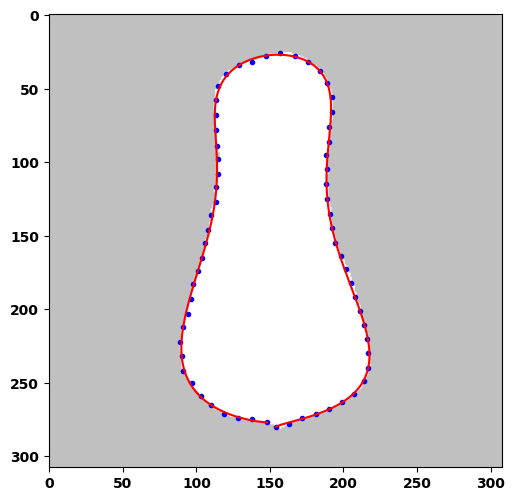

In [20]:
%%time
results= check1N(0,Nsamples=65,Nfrom=10,Nto=12,err_th=0.5,withFig=True)
results

12.
CP 5.0, steps:0, etime: 3.37500 err: 2.4371237028
.
CP 2.0, steps:1, etime: 5.45312 err: 1.9987080012
..................................................................
CP 1.0, steps:67, etime: 140.20312 err: 0.9998502570
................................
....................................................................................................
....................................................................................................
.....^........^.......^.......^.......^.........................................
CP 0.65, steps:379, etime: 776.56250 err: 0.6497710945
...................^
.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^...^.^^^^^^^^^^^............................
....................................................................................................
.........................................................................................^^^....^^^.
...^^^^..^^^..^^^^...^^^^^..^^....^^^..^^^..^^^...^^^^...^^^..^^^..^^^^...^^^^.

{'12': (array([], dtype=int64), 0.5828065035134059, 2856.40625),
 '13': (array([], dtype=int64), 0.5756469347755412, 2457.0)}

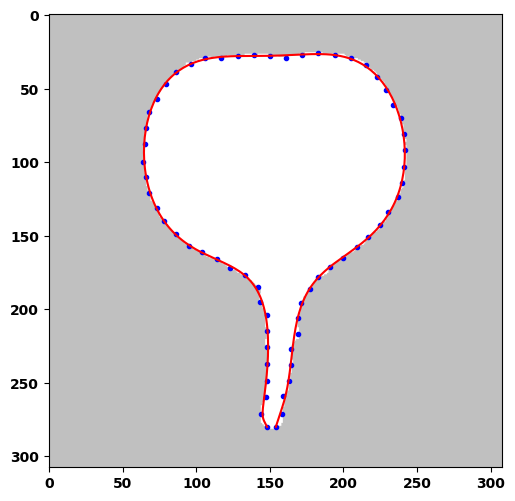

In [21]:
%%time
results= check1N(1,Nsamples=65,Nfrom=12,Nto=13,err_th=0.5,withFig=True)
results

14.
CP 5.0, steps:0, etime: 4.53125 err: 1.5455665797
.
CP 2.0, steps:1, etime: 7.23438 err: 1.3057528224
........
CP 1.0, steps:9, etime: 28.46875 err: 0.9921713407
..........................................................................................
.
CP 0.65, steps:100, etime: 269.06250 err: 0.6495147894
...................................................................................................
.....................................................................................^..............
....................................................................................................
....................................................................................................
...................................................................................C

15.
CP 5.0, steps:0, etime: 5.14062 err: 1.2791902272
.
CP 2.0, steps:1, etime: 8.14062 err: 1.0067243842
.
CP 1.0, steps:2, etime: 11.07812 err: 0.9141782292
......................................

{'14': (array([], dtype=int64), 0.5844989489705031, 1544.5),
 '15': (array([], dtype=int64), 0.499942761245881, 2164.734375)}

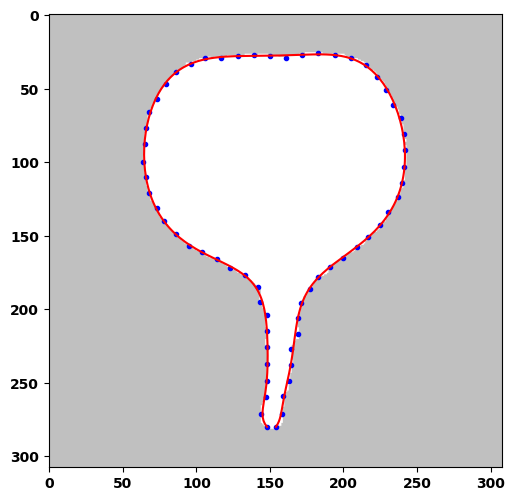

In [22]:
%%time
results= check1N(1,Nsamples=65,Nfrom=14,Nto=15,err_th=0.5,withFig=True)
results

14.
CP 5.0, steps:0, etime: 4.60938 err: 3.0971126372
...
CP 2.0, steps:3, etime: 12.65625 err: 1.7760791218
......
CP 1.0, steps:9, etime: 28.67188 err: 0.9740965931
............
CP 0.65, steps:21, etime: 60.59375 err: 0.6449359026
.....................................................E


N= 14  err = 0.49984023036974246   etime = 202.203125
Wall time: 3min 22s


{'14': (array([ 0, 62], dtype=int64), 0.49984023036974246, 202.203125)}

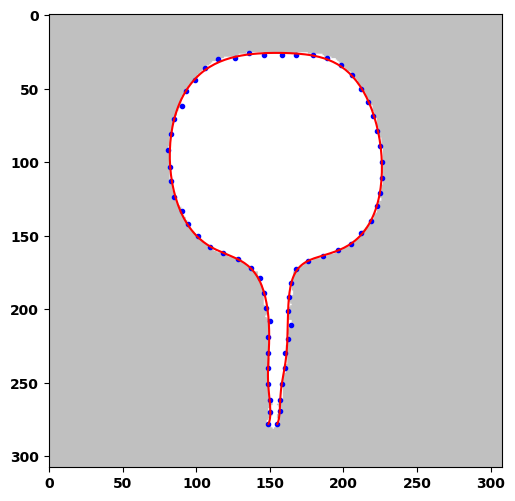

In [25]:
%%time
results= check1N(4,Nsamples=65,Nfrom=14,Nto=15,err_th=0.5,withFig=True)
results

17.
CP 5.0, steps:0, etime: 6.57812 err: 1.1571474277
.
CP 2.0, steps:1, etime: 10.37500 err: 0.9661832923
.
CP 1.0, steps:2, etime: 14.17188 err: 0.8715491530
.........
CP 0.65, steps:11, etime: 48.25000 err: 0.6465387556
...................................................................................E

18.
CP 5.0, steps:0, etime: 7.65625 err: 1.1274973274
.
CP 2.0, steps:1, etime: 12.06250 err: 0.9386457681
.
CP 1.0, steps:2, etime: 16.31250 err: 0.8513201800
..........
CP 0.65, steps:12, etime: 58.39062 err: 0.6479902086
.....................................................................................E


N= 18  err = 0.49978668692393624   etime = 419.34375
Wall time: 13min 5s


{'17': (array([ 0, 62], dtype=int64), 0.4995437179116113, 366.03125),
 '18': (array([ 0, 62], dtype=int64), 0.49978668692393624, 419.34375)}

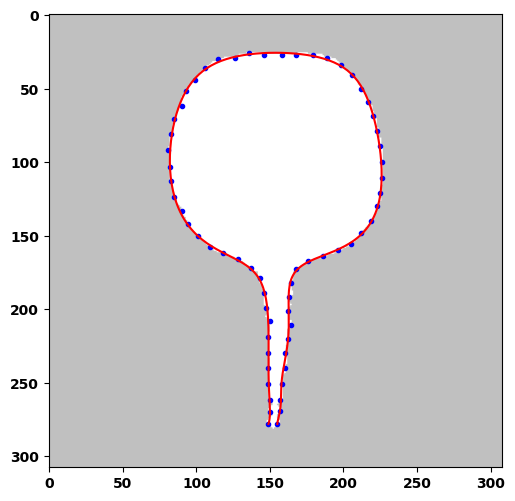

In [32]:
%%time
results= check1N(4,Nsamples=65,Nfrom=17,Nto=18,err_th=0.5,withFig=True)
results

In [31]:
results

{'15': (array([ 0, 62], dtype=int64), 0.49992894501979984, 955.296875),
 '16': (array([ 0, 62], dtype=int64), 0.4996438003044353, 601.46875)}

19.
CP 5.0, steps:0, etime: 8.14062 err: 1.0559677379
.
CP 2.0, steps:1, etime: 12.76562 err: 0.9373500873
.
CP 1.0, steps:2, etime: 17.37500 err: 0.8799108535
.............
CP 0.65, steps:15, etime: 77.56250 err: 0.6458787247
.......................................................E

20.
CP 5.0, steps:0, etime: 9.14062 err: 0.8051201115
.
CP 2.0, steps:1, etime: 14.21875 err: 0.6957019548
.
CP 1.0, steps:2, etime: 19.32812 err: 0.6372353317
.
CP 0.65, steps:3, etime: 24.45312 err: 0.6005908904
......E


N= 20  err = 0.49562618699914324   etime = 55.140625
Wall time: 6min 28s


{'19': (array([ 0, 62], dtype=int64), 0.4992104300751872, 333.8125),
 '20': (array([ 0, 62], dtype=int64), 0.49562618699914324, 55.140625)}

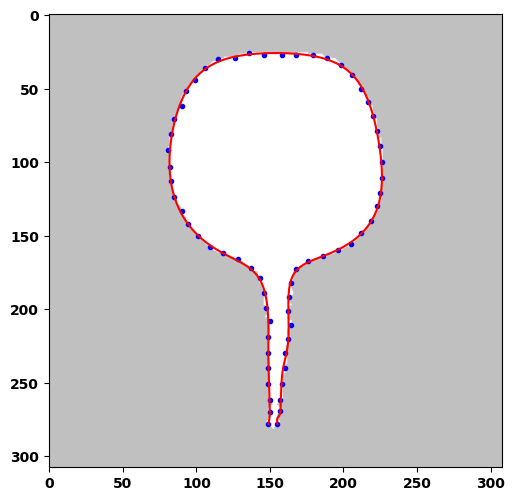

In [33]:
%%time
results= check1N(4,Nsamples=65,Nfrom=19,Nto=20,err_th=0.5,withFig=True)
results

13.
CP 5.0, steps:0, etime: 3.95312 err: 2.7426654355
....
CP 2.0, steps:4, etime: 13.37500 err: 1.9823140734
.........................................................................
CP 1.0, steps:77, etime: 186.00000 err: 0.9967476821
......................
....................................................................................................
...............................................^^........^^........^^.......^^.......^^......^^.....
^^.....^^.....^^.....^^^....^^^...
CP 0.65, steps:333, etime: 789.70312 err: 0.6498311056
.^^^....^^^....^^^...^^^....^^^...^^^....^^^...^^^....^^^...^^^...
.^^^...^^^...^^^....^^^^..^^^...^^^^...^^^^..^^^^...^^^^..^^^^..^^^^...^^^^..^^^^...^^^^..^^^^..^^^^
...^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^
^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^^^^.^^^^^^..^^^^^^..^^^^^^..^^^
^^^..^^^^^^..^^^^^^..^^^^^^..^^^^^^..^^^^^^..^^^^^^..^^^^^^..^^^^^^..^^^^^^.^^

{'13': (array([], dtype=int64), 0.6097861593199927, 5119.921875),
 '14': (array([], dtype=int64), 0.499161889558826, 1823.375)}

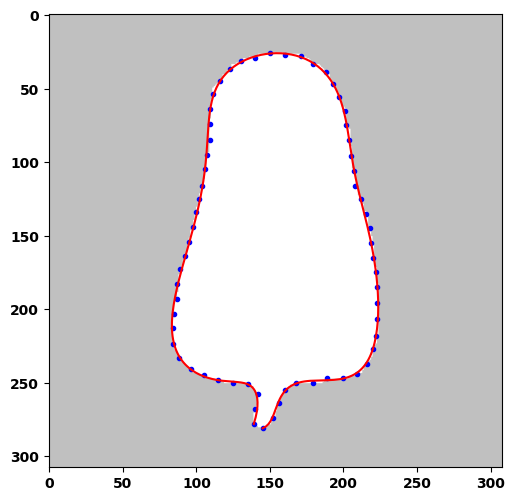

In [26]:
%%time
results= check1N(6,Nsamples=65,Nfrom=13,Nto=15,err_th=0.5,withFig=True)
results

10.
CP 5.0, steps:0, etime: 2.45312 err: 3.3022223281
.
CP 2.0, steps:1, etime: 3.95312 err: 1.9208375158
.....
CP 1.0, steps:6, etime: 11.51562 err: 0.9745679806
.............................
CP 0.65, steps:35, etime: 56.45312 err: 0.6462031362
................................................................
............................................................................^.^.^.^.^.^.^.^.^.^.^.^.
^.^.^.^.^.^^^^^.^^.^^.^^.^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^P

11.
CP 5.0, steps:0, etime: 2.90625 err: 2.7260625932
.
CP 2.0, steps:1, etime: 4.68750 err: 1.4593852020
..
CP 1.0, steps:3, etime: 8.20312 err: 0.8290585947
....
CP 0.65, steps:7, etime: 15.26562 err: 0.6279556745
.................E


N= 11  err = 0.4

{'10': (array([], dtype=int64), 0.5019067173237944, 799.953125),
 '11': (array([], dtype=int64), 0.49978718022962404, 45.28125)}

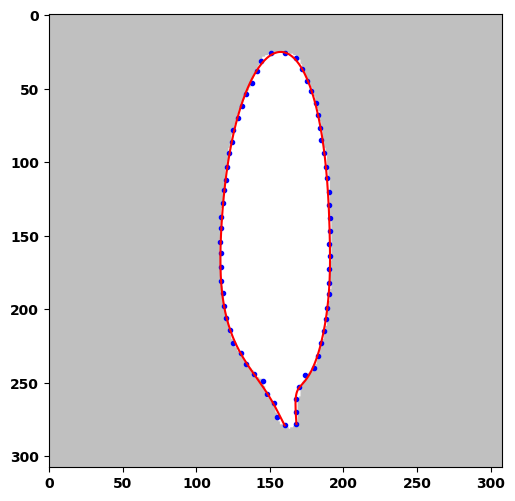

In [27]:
%%time
results= check1N(7,Nsamples=65,Nfrom=10,Nto=15,err_th=0.5,withFig=True)
results

11.
CP 5.0, steps:0, etime: 2.93750 err: 3.1194124673
..
CP 2.0, steps:2, etime: 6.53125 err: 1.6789317811
.................................................................................................
................
CP 1.0, steps:115, etime: 207.42188 err: 0.9980474802
....................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..................^...^^^........^^...................................
CP 0.65, steps:569, etime: 1010.90625 err: 0.6499521162
..............................
....................................................................................................
.........................................................^^^.............^^^.

{'11': (array([], dtype=int64), 0.5593145718210216, 4245.046875),
 '12': (array([], dtype=int64), 0.5420062101318642, 4807.84375),
 '13': (array([], dtype=int64), 0.4999829036892375, 3417.453125)}

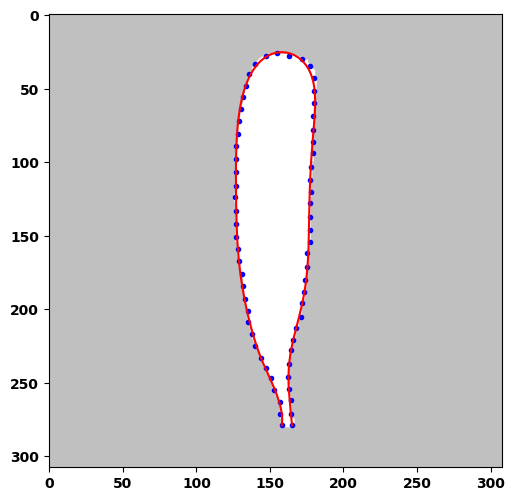

In [28]:
%%time
results= check1N(8,Nsamples=65,Nfrom=11,Nto=15,err_th=0.5,withFig=True)
results

13.
CP 5.0, steps:0, etime: 3.95312 err: 2.8151086698
......
CP 2.0, steps:6, etime: 17.95312 err: 1.9399769935
........................
CP 1.0, steps:30, etime: 74.39062 err: 0.9949206653
........................
CP 0.65, steps:54, etime: 130.68750 err: 0.6494674055
.................................E


N= 13  err = 0.49838705007241574   etime = 208.328125
Wall time: 3min 28s


{'13': (array([], dtype=int64), 0.49838705007241574, 208.328125)}

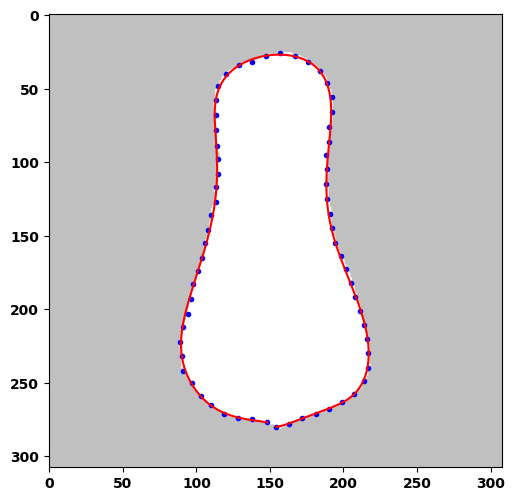

In [19]:
%%time
results= check1N(0,Nsamples=65,Nfrom=13,Nto=15,err_th=0.5,withFig=True)
results

ここから古い結果

In [11]:
import time
def checkN(imgnum,mode=0,Nsamples=65,Nprolog=3,Nfrom=5,Nto=7,lr=0.005,lrP=400,preTry=100,maxTry=1500,pat=10,err_th=0.5, threstune=1.0,moption=False):
    img = imgs[imgnum]
    config = wandb.config={
          'program':'checkN',
          ''
          'lr':lr,
          'maxTry':maxTry,
          'preTry':preTry,
          'pat':pat,
          'err_th':err_th}
    wandb.init(project="checkN %d" % imgnum,
                 config = config)
    rd.BezierCurve.wandb=wandb

    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')

    bez = rd.BezierCurve(N=0,samples=Samples) # インスタンス生成
    lastN,results = bez.fit2(mode=mode,Nprolog=Nprolog,Nfrom=Nfrom,Nto=Nto,pat=pat,lr=lr,lrP=lrP,err_th=err_th,preTry=preTry,maxTry=maxTry,withErr=True,withEC=True,threstune=threstune,moption=moption)
    cps,func,err = results[str(lastN)]
    rd.drawBez(img,stt=0.0,end=1.0,bezL=func,cntL=Samples)
    print("{:>3d}次でOK".format(lastN))
    return results,err

#from sympy import diff, Symbol, Matrix, symbols, solve, simplify, binomial, Abs, im, re, lambdify
import time

#from statistics import mean
def check1(imgnum,test='smoothness_coe',coe=0,Nsamples=65,N=7,itt=3,maxTry=3000,pat=300,err_th=1.0,threstune=1.0,wandb=None,withEC=False,trial=None):
    start = time.process_time()
    rd.BezierCurve.mloop_itt = itt
    if wandb:
      config = wandb.config={
          'program':'check1',
          'N':N,
          test:coe,
          'mloop_itt':itt,
          'maxTry':maxTry,
          'pat':pat,
          'err_th':err_th}
      #調整するパラメータを登録
      wandb.init(project="fit1t %d" % (imgnum),
                 config = config)
      wandb.run.name = "%d-%12.8f"%(imgnum,coe)
    rd.BezierCurve.wandb=wandb
    # rd.BezierCurve.eq_coe = coe
    img = imgs[imgnum]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=Nsamples,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    bestcps, bestfunc, minerror = bez.fit1T(maxTry=maxTry,withErr=True, withEC=withEC,tpara=[], pat=pat, err_th=err_th, threstune=threstune,moption=True)
    elapsed_time = time.process_time() - start
    rd.drawBez(img,stt=-0.00,end=1.00,bezL=bestfunc,cntL=Samples)
    odds = rd.isOverFitting(bestfunc,bez.ts,conAll)
    # print(bestfunc)
    if withEC:
        (error,trynum) = minerror
        return error,elapsed_time,trynum+1,bestcps,odds
    else:
        return minerror,elapsed_time,odds
    
def check1o(imgnum,N,err_th=1.0,maxTry=3000):
    return check1(imgnum,test='timetest',coe=0,Nsamples=65,N=N,itt=3,maxTry=maxTry,pat=300,err_th=err_th,threstune=1.0,wandb=None,withEC=True,trial=None)


.........
CP 5.0, steps:8, etime: 9.46875 err: 4.9155521100
......................
CP 2.0, steps:30, etime: 23.42188 err: 1.9581910067
.....................................................................
..............................E

Wall time: 1min 26s


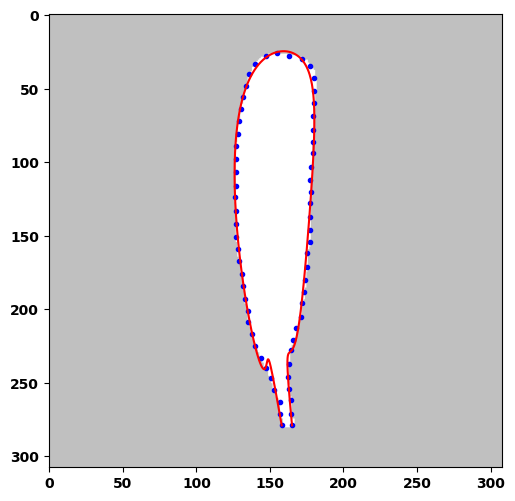

In [4]:
%%time
error,elapsed_time,trynum,bestcps,odds = check1o(8,N=8,err_th=1,maxTry=300)

................
CP 5.0, steps:15, etime: 13.42188 err: 4.7457027824
..................
CP 2.0, steps:33, etime: 24.85938 err: 1.9399811034
.......................E

Wall time: 39.6 s


array([57, 58], dtype=int64)

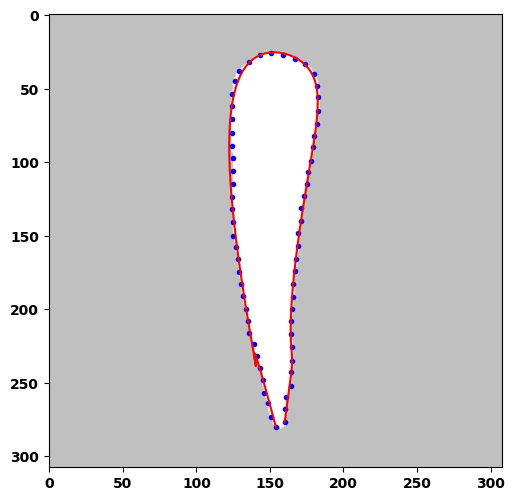

In [8]:
%%time
error,elapsed_time,trynum,bestcps,odds= check1o(3,N=8,err_th=1,maxTry=300)
odds

.
CP 5.0, steps:0, etime: 5.51562 err: 4.8604721078
...........
CP 2.0, steps:11, etime: 18.70312 err: 1.9775582850
.........................................E

Wall time: 1min 8s


array([], dtype=int64)

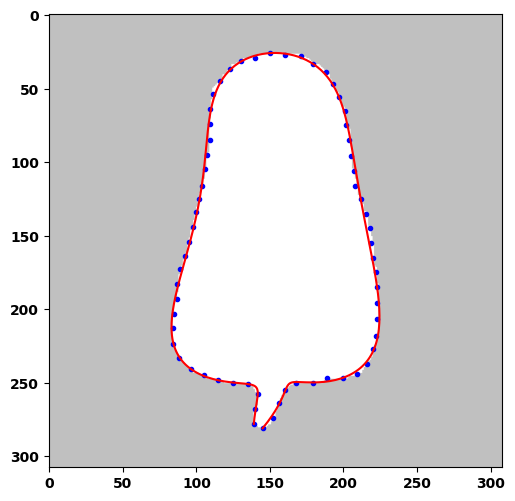

In [7]:
%%time
error,elapsed_time,trynum,bestcps,odds= check1o(6,N=11,err_th=1,maxTry=300)
odds

In [114]:
odds,rs

((array([4], dtype=int64),),
 array([1.25190287e+00, 1.26350238e-01, 1.20268673e+00, 5.37417820e-01,
        1.02653890e+01, 1.35457379e+00, 7.92606851e-01, 5.83768536e-01,
        8.10881332e-01, 1.48038849e-01, 6.04144753e-01, 3.54445451e-01,
        3.46539868e-01, 6.44160800e-01, 3.70226533e-01, 3.01028314e-01,
        1.03729055e-01, 2.30828494e-02, 3.62187341e-01, 4.28866735e-01,
        4.84667015e-03, 2.70820577e-02, 1.27833292e-02, 3.35007539e-01,
        3.20758226e-01, 3.29520510e-01, 5.54979369e-01, 5.89923199e-01,
        8.45620146e-01, 9.43464917e-01, 9.46640347e-01, 7.03152409e-01,
        2.93490144e-01, 3.56537988e-01, 1.06825673e+00, 1.12502245e+00,
        1.14281241e+00, 5.77309345e-02, 4.27458568e-01, 2.94783663e-02,
        1.19111585e-02, 8.28466114e-01, 3.68732641e-01, 3.63526684e-01,
        5.04387693e-01, 3.60804529e-01, 2.24162712e-02, 3.62257361e-02,
        8.55207481e-01, 6.99755438e-01, 4.06417124e-02, 4.07089293e-01,
        3.51953057e-01, 3.41605495e

In [112]:
odds,rs

((array([], dtype=int64),),
 array([0.39282809, 0.6712143 , 0.13593646, 0.37035519, 0.62219299,
        0.72020802, 0.82271413, 0.11824201, 0.94300585, 0.02794524,
        0.20461027, 0.50333407, 1.06334313, 0.65156411, 0.756968  ,
        0.77265616, 0.78328336, 0.62532041, 1.41348551, 0.61579555,
        0.68237007, 0.37358328, 0.68786648, 0.0369914 , 0.98399524,
        0.81896745, 1.04362564, 0.3836669 , 0.9611958 , 0.75362486,
        0.70002165, 0.28731052, 0.50655639, 0.77833706, 0.88200932,
        0.84017695, 0.85047353, 1.47188961, 0.48837715, 0.59988691,
        0.38430712, 0.63293394, 0.38126901, 1.10478126, 0.83980053,
        0.81581097, 0.3992802 , 0.3855854 , 0.62678565, 0.38221994,
        0.00718483, 0.12576333, 0.12012207, 0.39340283, 1.04858203,
        0.97662282, 1.08230856, 0.1217877 , 0.90800778, 0.00415852,
        0.24736231, 0.76745047, 1.10169051, 0.74875028]))

....................................................................................................
..............................
CP 5.0, steps:129, etime: 115.92188 err: 4.9754815680
...........................................................
CP 2.0, steps:188, etime: 168.54688 err: 1.9912531266
...........
................................................E

Wall time: 3min 40s


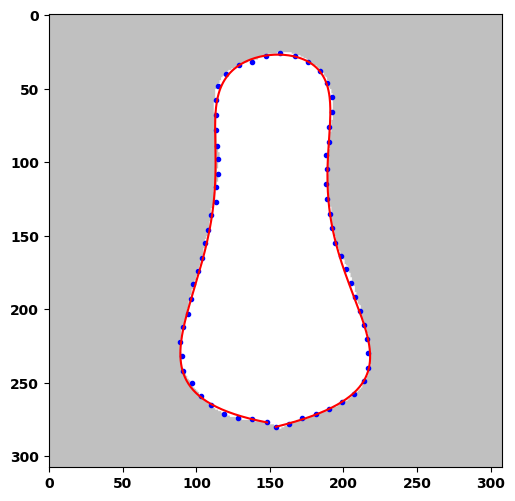

In [83]:
%%time
error,elapsed_time,trynum,bestcps,odds2,rs = check1o(0,N=7,err_th=1)

In [84]:
error,elapsed_time,trynum,bestcps,odds2,rs

(0.9928318042417327,
 220.59375,
 248,
 [[148.0, 277.0],
  [-151.29399611056826, 219.4134205014662],
  [789.073860101814, -51.32882198949079],
  [-1037.5623159966574, 80.53145271872849],
  [1384.232053223015, -78.22208335706274],
  [-545.945153907334, 45.67842150038166],
  [481.745652705276, 198.91659438436815],
  [154.0, 280.0]],
 [],
 array([4.77036203e-01, 6.61908706e-01, 8.61517037e-01, 8.11637646e-01,
        2.59775547e-01, 4.61575405e-01, 2.69585587e-01, 2.31406871e-01,
        4.64160200e-01, 6.52548356e-01, 7.58834759e-01, 6.35382026e-01,
        6.66569369e-01, 1.56857275e+00, 7.10350320e-01, 6.42488943e-01,
        5.69314691e-01, 5.48590725e-01, 1.81985773e+00, 8.48571109e-01,
        8.12026678e-01, 9.14442849e-01, 1.26580310e+00, 2.82283458e-01,
        7.79624391e-04, 1.09471044e+00, 9.95517754e-01, 1.14646383e+00,
        1.12942633e+00, 6.27875411e-01, 6.80283119e-01, 7.34509267e-01,
        6.77767717e-01, 7.92700190e-01, 5.69633320e-01, 8.90474076e-01,
        9.5868

....................................................................................................
..............................
CP 5.0, steps:129, etime: 115.17188 err: 4.9754815680
...........................................................
CP 2.0, steps:188, etime: 167.45312 err: 1.9912531266
...........
................................................E

Wall time: 3min 39s


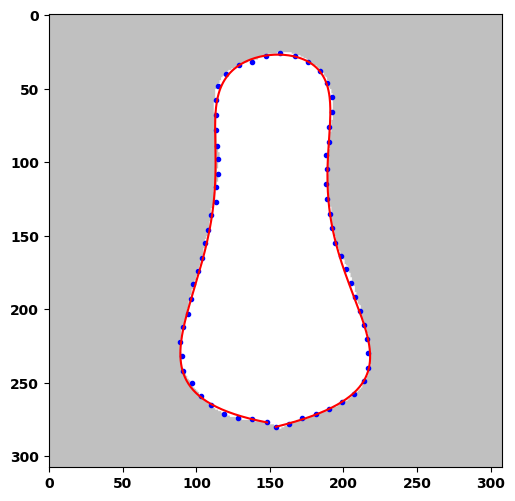

In [18]:
%%time
error,elapsed_time,trynum,bestcps,odds2,rs = check1o(0,N=7,err_th=1)

In [36]:
img = imgs[0]
conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
Samples = rd.getSamples(conAll,N=65,mode='Equidistant')
axlength = np.array(cv2.arcLength(conAll, closed=False))  # 弧長
lengths = np.array([cv2.arcLength(conAll[:i+1], closed=False)
                            for i in range(len(conAll))])  

np.array([cont[np.abs(np.asarray(lengths) - i).argmin()] for i in np.linspace(0, axlength, N)])

d=Samples[1:]-Samples[:-1]
d1=np.sqrt(np.sum(d*d,axis=1))

(0.47986114480398256, 9.926497785307133)

....................................................................................................
..............................
CP 5.0, steps:129, etime: 115.14062 err: 4.9754815680
...........................................................
CP 2.0, steps:188, etime: 167.29688 err: 1.9912531266
...........
................................................E

Wall time: 3min 40s


(0.9928318042417327,
 219.9375,
 248,
 [[148.0, 277.0],
  [-151.29399611056826, 219.4134205014662],
  [789.073860101814, -51.32882198949079],
  [-1037.5623159966574, 80.53145271872849],
  [1384.232053223015, -78.22208335706274],
  [-545.945153907334, 45.67842150038166],
  [481.745652705276, 198.91659438436815],
  [154.0, 280.0]],
 [57])

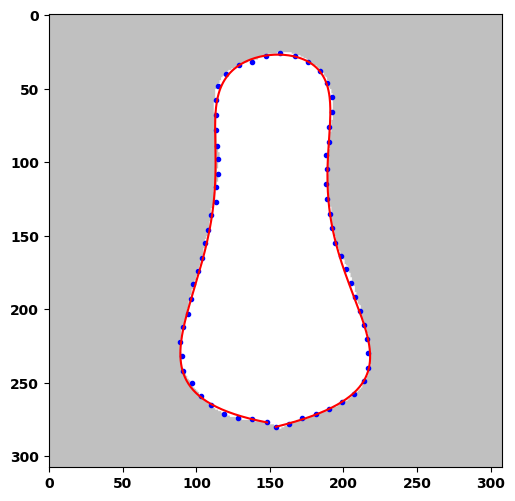

In [5]:
%%time
check1o(0,N=7,err_th=1)

....
CP 5.0, steps:3, etime: 7.04688 err: 4.9657430428
................................................................................................
..............................................................................
CP 2.0, steps:177, etime: 274.10938 err: 1.9972871154
.....................^
^^..................................................................................................
....................................................................................................
......................................................E

Wall time: 11min 38s


(0.9992702880833091,
 696.984375,
 454,
 [[148.0, 280.0],
  [118.61613150275349, 248.09959666859146],
  [395.7394511266474, -571.639872817458],
  [-789.4138095301531, 2499.8134123620903],
  [986.0108515163761, -4567.215934747895],
  [-479.6985609659711, 5506.708912034776],
  [313.4940600765156, -4497.102387306554],
  [569.0467366622273, 2392.6985681536835],
  [71.89314573499409, -524.4040722494107],
  [196.23519010792725, 235.4533189408992],
  [154.0, 280.0]],
 [])

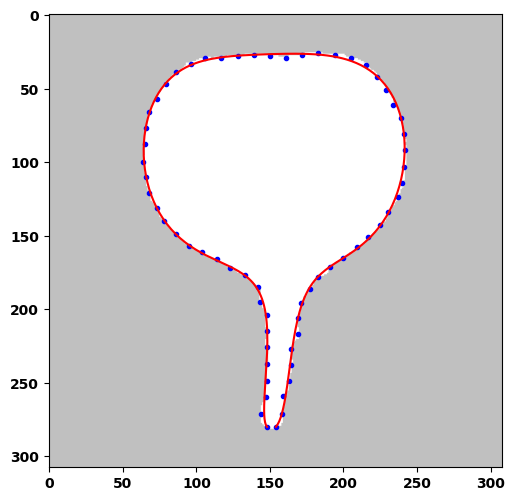

In [6]:
%%time
check1o(1,N=10,err_th=1)

.......
CP 5.0, steps:6, etime: 8.09375 err: 4.7033632475
..........................
CP 2.0, steps:32, etime: 35.59375 err: 1.9972090212
...............................^...^.....^...^...^...^^..^^..^^..^^
^.^^^.^^^.^^^.^^^.^^^.^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^.^^^.^^^.^^^.^^^.^^^.^^^.^^^^^.^^^^..^^^^..
^^..^...^^^...^^....^^....^^....^^^^^.^.............................................................
....................................................................................................
....................................................................................................
.......................................^...^.^...^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^......^.........
....................................................................................................
...............................................................................................^^...
..^^....^^....^^....^......^......................................................^..^..

(0.9995402474983928,
 1401.078125,
 1289,
 [[170.0, 276.0],
  [192.75280526350818, 228.76524672896062],
  [-75.92022820802696, -99.58350865218362],
  [629.792945836349, 356.3514129338051],
  [-143.95112319921887, -427.9479208888621],
  [269.81274433385875, 195.79520175602954],
  [47.732618963134954, 170.58535856631147],
  [118.09786177942622, 166.88684880598925],
  [166.0, 281.0]],
 [11])

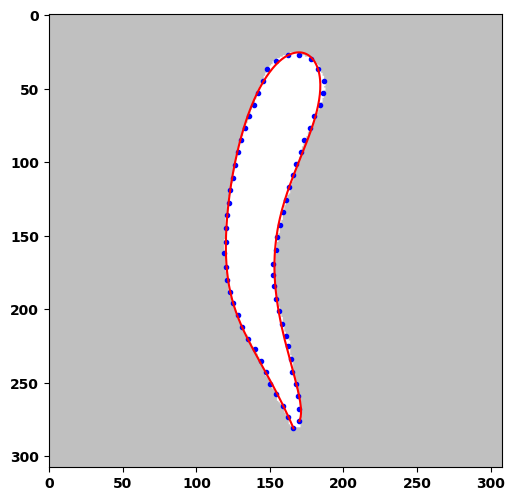

In [7]:
%%time
check1o(2,N=8,err_th=1)

.........................
CP 5.0, steps:24, etime: 27.21875 err: 4.9997705179
.........................................
CP 2.0, steps:65, etime: 71.07812 err: 1.9944184702
..................................
..............................................................................................^^^^^^
^^^^^^^^^^^^^^^^^^^^.^.^.^.^.^.^..^..^.^^^^^^^.^.^.^.^.^....^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.
^.^.^.^.^.^.^.^.^^^^^^^^^^..^..^^^..^^^.^..^^^.^^^.^^^.^^^.^^^^^^^^^^^^.^^^^^..^^^^.E

Wall time: 6min 49s


(0.9999188713700999,
 409.203125,
 384,
 [[160.0, 277.0],
  [179.24684116337383, 149.1337659861942],
  [132.8137392379809, 435.933698124693],
  [154.74818809426455, -825.0483427823353],
  [496.8525768931499, 1312.0848224828014],
  [-308.3929536609908, -1421.5701092461813],
  [334.76262312328123, 956.2376111735881],
  [82.05935648945994, 26.0836619458296],
  [154.0, 280.0]],
 [])

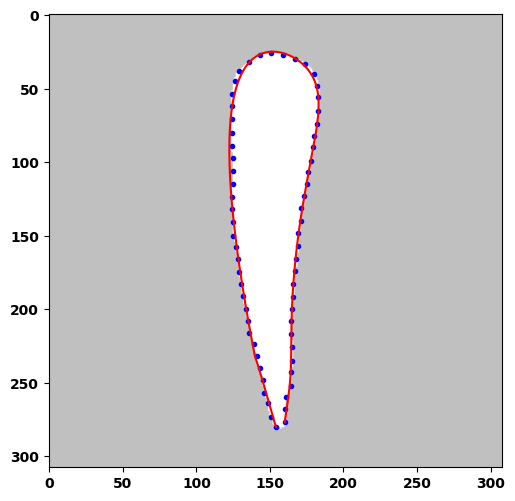

In [8]:
%%time
check1o(3,N=8,err_th=1)

....................................................................................................
.........................
CP 5.0, steps:124, etime: 112.85938 err: 4.9994797939
......................................................
CP 2.0, steps:178, etime: 161.28125 err: 1.9866134492
.....................
....................................E

Matrix([[156.0*t**7 + 483.118348243932*t**6*(7 - 7*t) - 11653.0158832172*t**5*(1 - t)**2 + 49345.9285437072*t**4*(1 - t)**3 - 37229.0867831506*t**3*(1 - t)**4 + 16847.6310050477*t**2*(1 - t)**5 - 1109.91711568668*t*(1 - t)**6 + 149.0*(1 - t)**7], [281.0*t**7 + 197.045645929431*t**6*(7 - 7*t) + 650.626482226449*t**5*(1 - t)**2 - 1834.83968507691*t**4*(1 - t)**3 + 1900.30864868618*t**3*(1 - t)**4 - 853.010000974869*t**2*(1 - t)**5 + 1518.55924828118*t*(1 - t)**6 + 279.0*(1 - t)**7]])
check1 212.46875
Wall time: 3min 32s


(0.9988578232247216, 212.4375, 235)

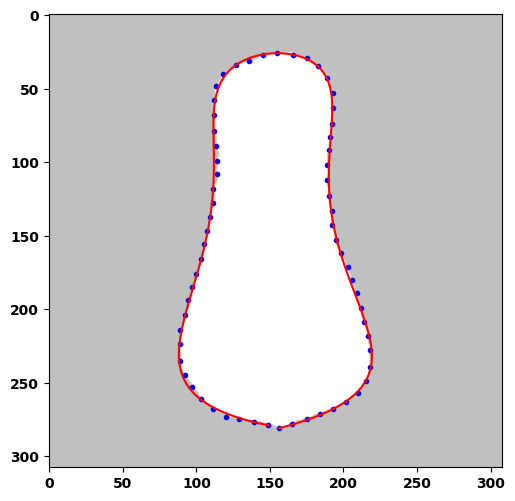

In [21]:
%%time
check1o(0,N=7,err_th=1)

....
CP 5.0, steps:3, etime: 7.06250 err: 4.9114697308
................................................................................................
.............................................
CP 2.0, steps:144, etime: 223.87500 err: 1.9937037462
.......................................................
....................................................................................................
............................E

Matrix([[154.0*t**10 + 192.921553444899*t**9*(10 - 10*t) + 4360.51273398395*t**8*(1 - t)**2 + 54310.2770108428*t**7*(1 - t)**3 + 108483.755825388*t**6*(1 - t)**4 - 155744.629686875*t**5*(1 - t)**5 + 208379.546085914*t**4*(1 - t)**6 - 91468.4642548878*t**3*(1 - t)**7 + 17517.5747846797*t**2*(1 - t)**8 + 1186.84922455118*t*(1 - t)**9 + 147.0*(1 - t)**10], [280.0*t**10 + 272.434567162008*t**9*(10 - 10*t) - 28578.2752085978*t**8*(1 - t)**2 + 314225.973029355*t**7*(1 - t)**3 - 998923.491804014*t**6*(1 - t)**4 + 1440865.92567987*t**5*(1 - t)**5 - 990972.777763

(0.9985594572141915, 504.09375, 327)

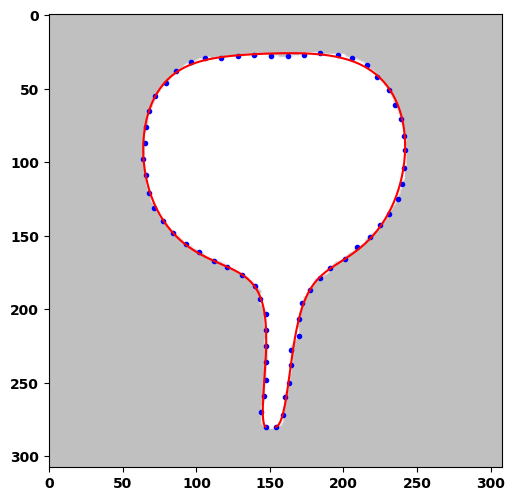

In [22]:
%%time
check1o(1,N=10,err_th=1)

....................................................................................................
....................................................................................................
....................................................................................................
..........C

Matrix([[154.0*t**9 + 197.374552741617*t**8*(9 - 9*t) + 4857.02529569667*t**7*(1 - t)**2 + 2142.29443169751*t**6*(1 - t)**3 + 169429.709461242*t**5*(1 - t)**4 - 131804.256361947*t**4*(1 - t)**5 + 22437.471131098*t**3*(1 - t)**6 + 6649.33028989732*t**2*(1 - t)**7 + 1228.66196493979*t*(1 - t)**8 + 147.0*(1 - t)**9], [280.0*t**9 + 158.495020843706*t**8*(9 - 9*t) + 4590.95982601289*t**7*(1 - t)**2 + 26596.8176709221*t**6*(1 - t)**3 - 7817.4947526308*t**5*(1 - t)**4 - 74668.7151505139*t**4*(1 - t)**5 + 60340.2162721636*t**3*(1 - t)**6 - 1448.66289950885*t**2*(1 - t)**7 + 1712.05676724684*t*(1 - t)**8 + 280.0*(1 - t)**9]])
check1 397.375
Wall time: 6min 37s


(5.609614169249662, 397.34375, 309)

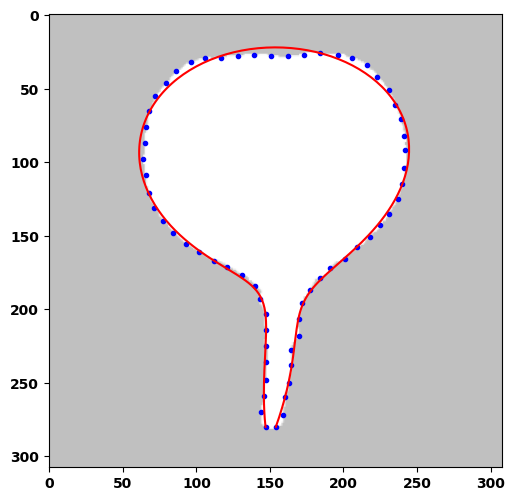

In [23]:
%%time
check1o(1,N=9,err_th=1)

.
CP 5.0, steps:0, etime: 2.92188 err: 4.1994489759
...
CP 2.0, steps:3, etime: 8.20312 err: 1.9165595822
...............................E

Matrix([[167.0*t**11 + 126.51398840692*t**10*(11 - 11*t) + 17049.5888309181*t**9*(1 - t)**2 - 113449.841340899*t**8*(1 - t)**3 + 630247.319981614*t**7*(1 - t)**4 - 1193367.20995888*t**6*(1 - t)**5 + 1315696.48527612*t**5*(1 - t)**6 - 418650.949458046*t**4*(1 - t)**7 + 99153.2497921939*t**3*(1 - t)**8 + 2756.65254757119*t**2*(1 - t)**9 + 1964.81263826819*t*(1 - t)**10 + 171.0*(1 - t)**11], [281.0*t**11 + 235.564434305673*t**10*(11 - 11*t) + 21665.2663599357*t**9*(1 - t)**2 - 127773.799989702*t**8*(1 - t)**3 + 706578.446418229*t**7*(1 - t)**4 - 1145574.33695432*t**6*(1 - t)**5 + 771933.240582176*t**5*(1 - t)**6 - 269860.211296756*t**4*(1 - t)**7 + 84545.3751546985*t**3*(1 - t)**8 + 4904.51292949661*t**2*(1 - t)**9 + 2602.43734442408*t*(1 - t)**10 + 277.0*(1 - t)**11]])
check1 63.390625
Wall time: 1min 3s


(0.9973971806342182, 63.34375, 34)

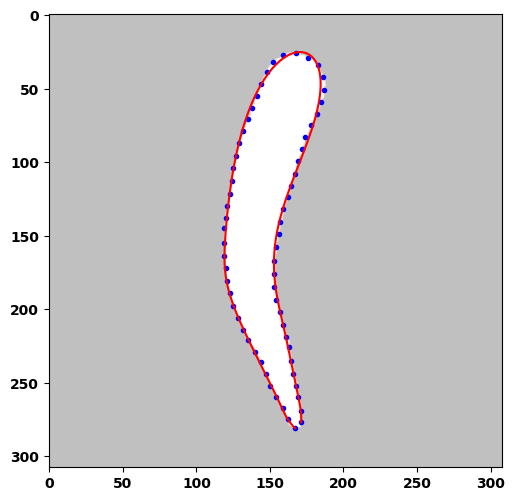

In [24]:
%%time
check1o(2,N=11,err_th=1)

..
CP 5.0, steps:1, etime: 3.98438 err: 4.7032148865
.............
CP 2.0, steps:14, etime: 23.81250 err: 1.9459221557
.....................................................................................
...
CP 1.0, steps:102, etime: 158.51562 err: 0.9986826579
.................................................................................................
........................................^.......^........^.......^^......^^.......^^......^^......^^
.......^^......^^.......^^.......^^.......^^.......^^........^^........^^........^^.........^^......
...^^..........^^..........^^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......................................
...................................^^.................................................^...........^.
..........^..........^..........^.......^......^......^......^.......^......^......^.......^......^.
.....^.....^^^^^.^.^.^.^.^.^.^^^^^^^^^^^^^^^^^^.....................................................
...................
CP 0.65, step

(0.5315480146997138, 4623.375, 3000)

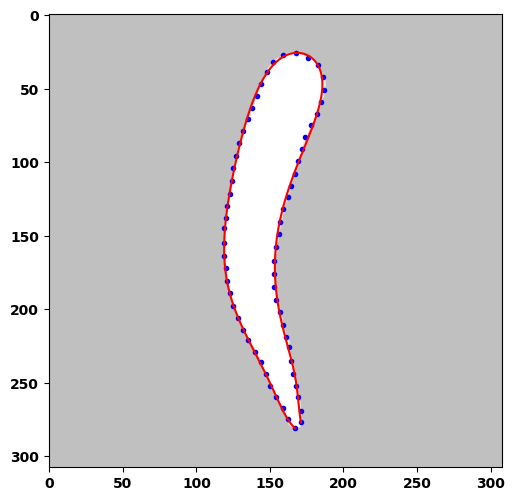

In [26]:
%%time
check1o(2,N=10,err_th=0.5)

..
CP 5.0, steps:1, etime: 3.98438 err: 4.7032148865
.............
CP 2.0, steps:14, etime: 23.71875 err: 1.9459221557
.....................................................................................
...E

Matrix([[167.0*t**10 + 138.6911202936*t**9*(10 - 10*t) + 4733.27447469667*t**8*(1 - t)**2 + 10060.281312049*t**7*(1 - t)**3 + 50000.5163256106*t**6*(1 - t)**4 - 69259.0481796054*t**5*(1 - t)**5 + 206320.301311299*t**4*(1 - t)**6 - 45694.5621616628*t**3*(1 - t)**7 + 13648.4384762294*t**2*(1 - t)**8 + 1461.14759968298*t*(1 - t)**9 + 171.0*(1 - t)**10], [281.0*t**10 + 253.717494251902*t**9*(10 - 10*t) + 2191.72122028479*t**8*(1 - t)**2 + 44995.1085973825*t**7*(1 - t)**3 + 56369.7785296857*t**6*(1 - t)**4 - 268330.186555013*t**5*(1 - t)**5 + 243444.877073055*t**4*(1 - t)**6 - 80442.5561596891*t**3*(1 - t)**7 + 22349.4498745145*t**2*(1 - t)**8 + 1675.91545219791*t*(1 - t)**9 + 277.0*(1 - t)**10]])
check1 156.578125
Wall time: 2min 36s


(0.9986826579351933, 156.546875, 102)

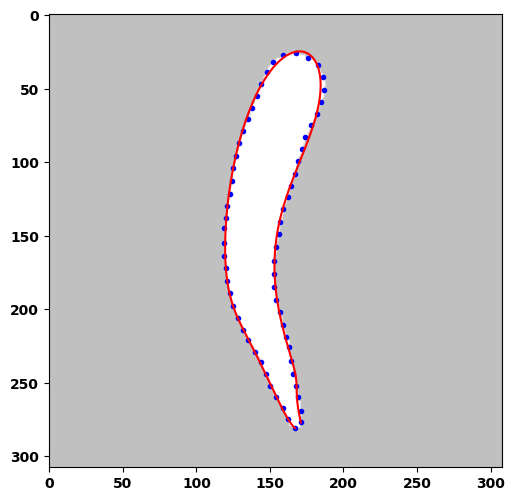

In [25]:
%%time
check1o(2,N=10,err_th=1)

18fit0andDraw 1.65625

N= 18  err = 0.9622668147162174
Wall time: 1.67 s


(Matrix([
 [154.0*t**18 + 202.36290783124*t**17*(18 - 18*t) - 18514.6946859625*t**16*(1 - t)**2 + 1256138.77863268*t**15*(1 - t)**3 - 12412174.1329181*t**14*(1 - t)**4 + 75783877.8215526*t**13*(1 - t)**5 - 199226007.423165*t**12*(1 - t)**6 + 231321190.567721*t**11*(1 - t)**7 + 263997600.842014*t**10*(1 - t)**8 - 1135547965.12903*t**9*(1 - t)**9 + 1635008668.73935*t**8*(1 - t)**10 - 1270404257.89067*t**7*(1 - t)**11 + 586104789.627771*t**6*(1 - t)**12 - 159333375.619724*t**5*(1 - t)**13 + 24627711.8280854*t**4*(1 - t)**14 - 1776944.87167595*t**3*(1 - t)**15 + 94272.8641219263*t**2*(1 - t)**16 + 1618.35465786999*t*(1 - t)**17 + 147.0*(1 - t)**18],
 [    280.0*t**18 + 296.128052354471*t**17*(18 - 18*t) - 41160.9889916843*t**16*(1 - t)**2 + 2275695.51317799*t**15*(1 - t)**3 - 30659189.6895629*t**14*(1 - t)**4 + 250855209.1683*t**13*(1 - t)**5 - 1206187701.9989*t**12*(1 - t)**6 + 3690871041.59895*t**11*(1 - t)**7 - 7212681434.25155*t**10*(1 - t)**8 + 9006820043.43573*t**9*(1 - t)**9 - 71863

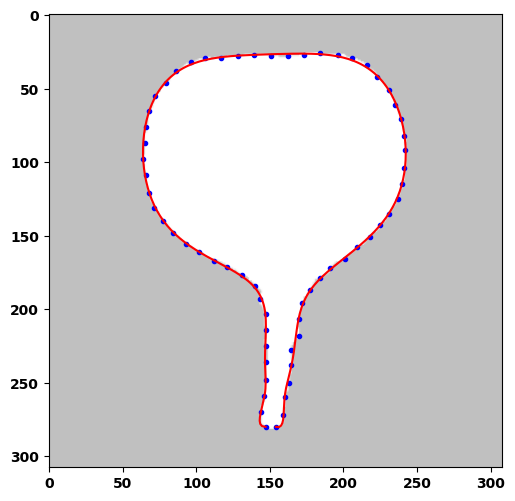

In [5]:
%%time
check0N(1,Nsamples=65,Nfrom=18,Nto=18,err_th=1,withFig=True);

..............................
CP 5.0, steps:29, etime: 27.04688 err: 4.9855785880
......................................................................
....................................................................................................
..................................
CP 2.0, steps:233, etime: 206.39062 err: 1.9985533694
..................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(1.176536493179981, 2662.515625, 3000)

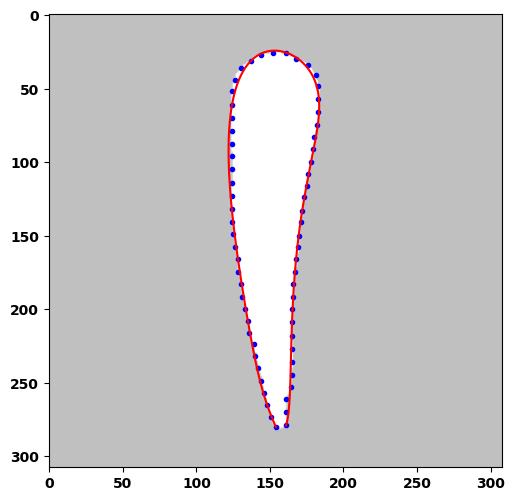

In [29]:
%%time
check1o(3,N=7,err_th=1)

........................
CP 5.0, steps:23, etime: 26.50000 err: 4.9814596054
..........................................
CP 2.0, steps:65, etime: 71.43750 err: 1.9994802153
........................^.^.^.^.^.
^.^.^.^.^.......................................................^^^..^^^..........^^^.^^^^...^^^^^..
....................................................................................................
............^^^^^^^^^^^^^^^^^^^^^^^..
CP 1.0, steps:336, etime: 359.48438 err: 0.9970490092
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^^^^^^^^^^^^^^.^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^P

Matrix([[154.0*t**8 + 73.1320008511007*t**7*(8 - 8*t) + 10175.5288977274*t**6*(1 - t)**2 - 20336.2396486089*t**5*(1 - t)**3 + 39150.25219

(0.9967364547702063, 738.09375, 692)

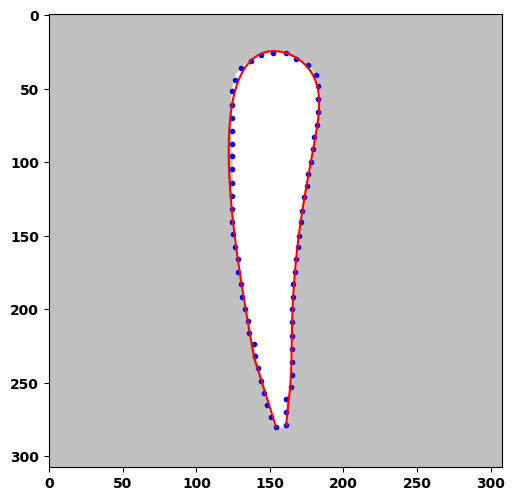

In [30]:
%%time
check1o(3,N=8,err_th=0.5)

...........
CP 5.0, steps:10, etime: 20.92188 err: 4.9089459791
.........................................................................................
...........................
CP 2.0, steps:126, etime: 229.01562 err: 1.9972432324
.........................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................E

Matrix([[154.0*t**11 + 176.068574046041*t**10*(11 - 11*t) + 8807.65946989639*t**9*(1 - t)**2 + 7863.62639844715*t**8*(1 - t)**3 + 295519.0

(0.9987621013517469, 1347.0625, 743)

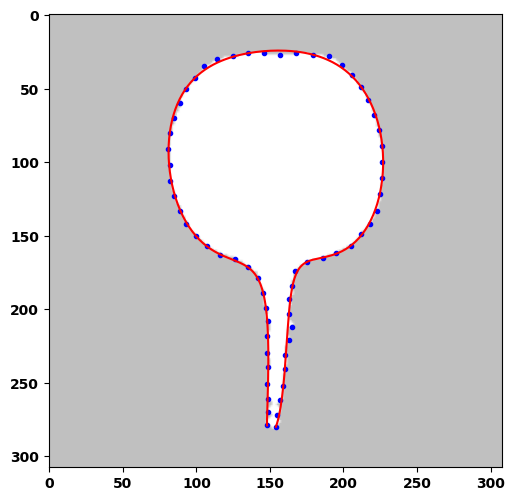

In [31]:
%%time
check1o(4,N=11,err_th=1.0)

............
CP 5.0, steps:11, etime: 19.60938 err: 4.9311877759
............................................................................^^..........
...............................^....................................................................
....................................................................................................
......................................
CP 2.0, steps:337, etime: 525.39062 err: 1.9990344124
..............................................................
.......^^^^.....^^^^^^...^^^........................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................

(0.8724085454806223, 4090.921875, 2621)

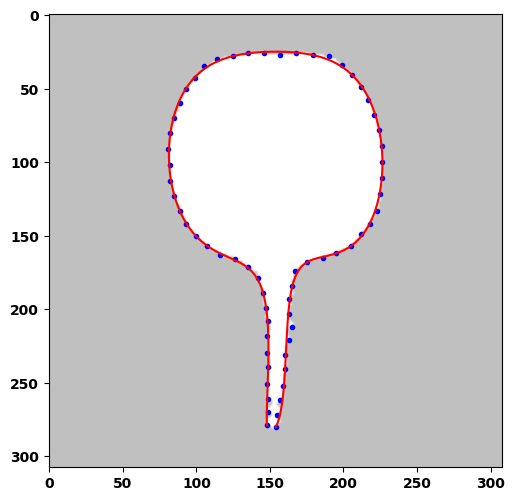

In [32]:
%%time
check1o(4,N=10,err_th=0.5)

.
CP 5.0, steps:0, etime: 2.07812 err: 3.6319228902
.............................
CP 2.0, steps:29, etime: 39.78125 err: 1.9884173238
......................................................................
....................................................................................................
.............E

Matrix([[156.0*t**9 + 153.970306917541*t**8*(9 - 9*t) + 18196.6531241072*t**7*(1 - t)**2 - 49702.1619124689*t**6*(1 - t)**3 + 202650.202505606*t**5*(1 - t)**4 - 163928.429940325*t**4*(1 - t)**5 + 75851.6886819548*t**3*(1 - t)**6 - 7332.48605361786*t**2*(1 - t)**7 + 1318.79759856068*t*(1 - t)**8 + 150.0*(1 - t)**9], [279.0*t**9 + 174.815350295249*t**8*(9 - 9*t) + 14546.489662395*t**7*(1 - t)**2 - 23847.5742177345*t**6*(1 - t)**3 + 23315.047553471*t**5*(1 - t)**4 - 8314.87633409908*t**4*(1 - t)**5 - 8661.27317677805*t**3*(1 - t)**6 + 11979.3158280596*t**2*(1 - t)**7 + 1474.55776906787*t*(1 - t)**8 + 279.0*(1 - t)**9]])
check1 280.859375
Wall time: 4min 40s


(0.9997826913794351, 280.828125, 212)

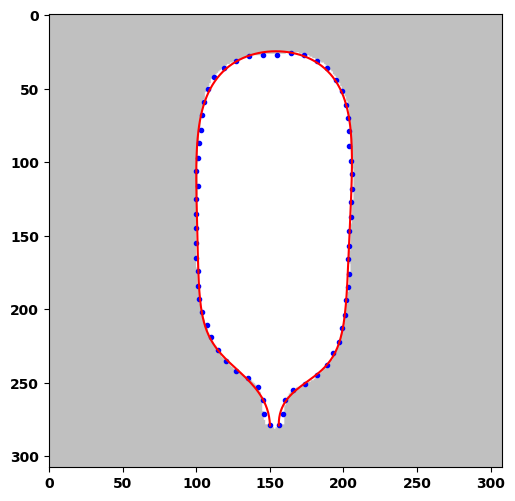

In [33]:
%%time
check1o(5,N=9,err_th=1.0)

............
CP 5.0, steps:11, etime: 13.43750 err: 4.6916226137
........................................................................................
................................
CP 2.0, steps:131, etime: 142.01562 err: 1.9980367034
................................................................^...
...^......^.......^.......^.......^.......^.......^.......^.......^.......^.......^^^.....^^.....^^.
.....^^......^^......^^......^^......^^....^^....^^....^^....^^....^^....^^....^^....^^....^^....^^^
.....^^^....^^^....^^^....^^^....^^^....^^^...^^^^..................................................
.....................................................................^^..........
CP 1.0, steps:580, etime: 629.45312 err: 0.9999642395
.......^^..........
..^^..........^^........^^........^^.......^^......^^.....^^.....^^.....^^.....^^....^^....^^....^^.
...^^...^^...^^...^^...^^^....^^^...^^^...^^^...^^^...^^^...^^^...^^^...^^^...^^^...^^^..^^^...^^^..
.^^^^...^^^..^^^...^^^..^^^..

(0.9007668668648259, 3235.265625, 3000)

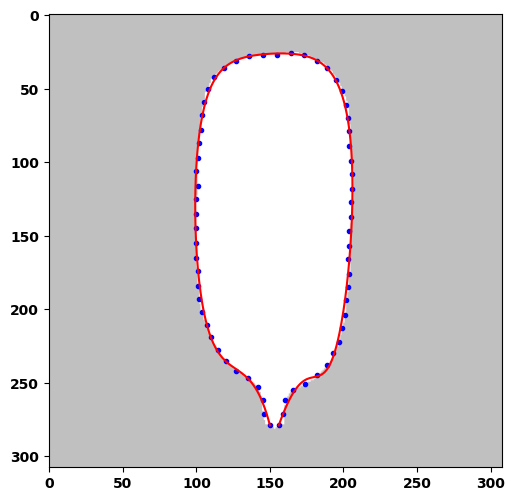

In [34]:
%%time
check1o(5,N=8,err_th=0.5)

.
CP 5.0, steps:0, etime: 3.43750 err: 3.2307638368
.......................
CP 2.0, steps:23, etime: 51.12500 err: 1.9832761699
..............................................................E

Matrix([[144.0*t**12 + 206.030209898722*t**11*(12 - 12*t) - 3136.41105643997*t**10*(1 - t)**2 + 245583.123365048*t**9*(1 - t)**3 - 344838.991149069*t**8*(1 - t)**4 - 476557.69173735*t**7*(1 - t)**5 + 3719892.48179318*t**6*(1 - t)**6 - 4341518.23634004*t**5*(1 - t)**7 + 2239259.30978208*t**4*(1 - t)**8 - 422044.218513598*t**3*(1 - t)**9 + 31327.7481026331*t**2*(1 - t)**10 + 1505.82733065441*t*(1 - t)**11 + 138.0*(1 - t)**12], [281.0*t**12 + 279.826479833131*t**11*(12 - 12*t) - 18860.9281082089*t**10*(1 - t)**2 + 579750.071051618*t**9*(1 - t)**3 - 2937120.24019688*t**8*(1 - t)**4 + 7808182.59618334*t**7*(1 - t)**5 - 10586735.2360216*t**6*(1 - t)**6 + 7418731.331558*t**5*(1 - t)**7 - 2623457.87254507*t**4*(1 - t)**8 + 460919.163343595*t**3*(1 - t)**9 - 6284.52759102359*t**2*(1 - t)**10 + 3023.131838

(0.9931485177096444, 182.140625, 85)

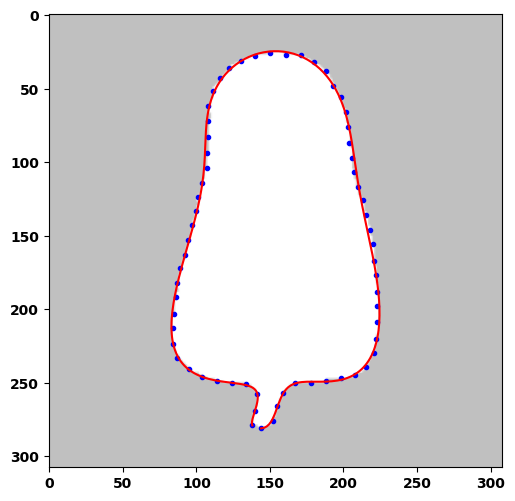

In [35]:
%%time
check1o(6,N=12,err_th=1)

HERE

..............
CP 5.0, steps:13, etime: 12.51562 err: 4.9715770942
......................................................................................
....................
CP 2.0, steps:119, etime: 103.96875 err: 1.9992877280
................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................

(1.1102271933873824,
 1270.59375,
 1449,
 [[171.0, 277.0],
  [179.17025876980858, 198.61615474405716],
  [-35.054766201493436, -62.22263958403282],
  [581.9242215306275, 352.4563486966853],
  [-109.20662597617388, -559.5838358228499],
  [214.1527110342631, 444.81718061636343],
  [59.41439350578946, 74.90736288441704],
  [167.0, 281.0]])

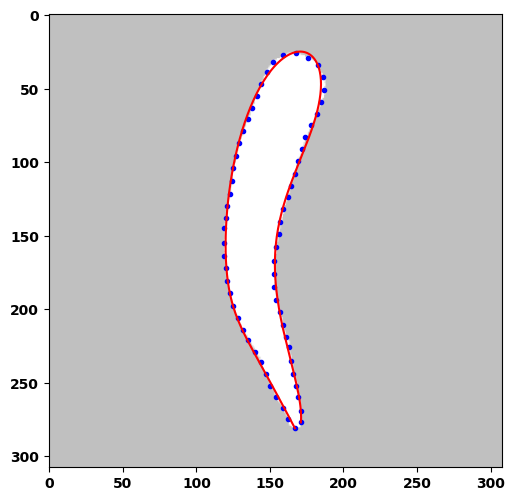

In [5]:
%%time
check1o(2,N=7,err_th=0.5)

.
CP 5.0, steps:0, etime: 2.96875 err: 4.9055952967
.........................................
CP 2.0, steps:41, etime: 77.18750 err: 1.9975175450
..........................................................
.......................................................................................
CP 1.0, steps:186, etime: 338.95312 err: 0.9997394962
.............
..............................................^^^^^^^^^^^...........................................
....................................................................................................
..............^^^^^^^^^^...........................^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^........^..
...............^^^^^^^^^^^^^^.......................................................................
..................^^^^^^^^^^^^^^^^^^^^^^^^^^^^......................................................
.................................

(0.6620507571875139, 2932.640625, 1592)

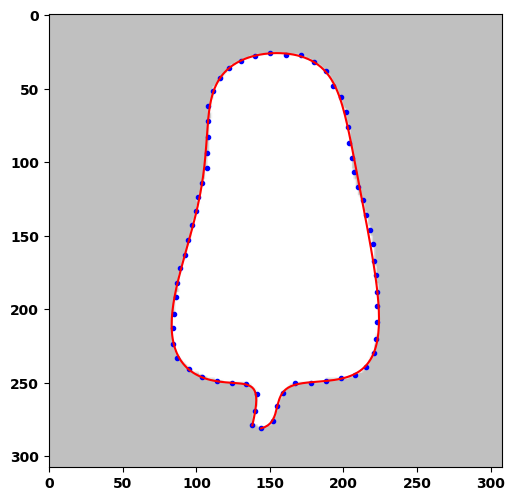

In [36]:
%%time
check1o(6,N=11,err_th=0.5)

...
CP 5.0, steps:2, etime: 3.07812 err: 2.8873477505
.
CP 2.0, steps:3, etime: 3.96875 err: 1.8986485062
......E

Matrix([[161.0*t**7 + 104.814586877423*t**6*(7 - 7*t) + 2394.10940742843*t**5*(1 - t)**2 + 1579.62133653819*t**4*(1 - t)**3 + 9309.31331520385*t**3*(1 - t)**4 + 3932.01862206446*t**2*(1 - t)**5 + 1376.30746036342*t*(1 - t)**6 + 168.0*(1 - t)**7], [281.0*t**7 + 177.606146069944*t**6*(7 - 7*t) + 5905.55201374642*t**5*(1 - t)**2 - 89.402506443145*t**4*(1 - t)**3 - 14805.0014690354*t**3*(1 - t)**4 + 9520.77867812538*t**2*(1 - t)**5 + 899.786433032389*t*(1 - t)**6 + 279.0*(1 - t)**7]])
check1 9.609375
Wall time: 9.58 s


(0.9757345386376545, 9.578125, 9)

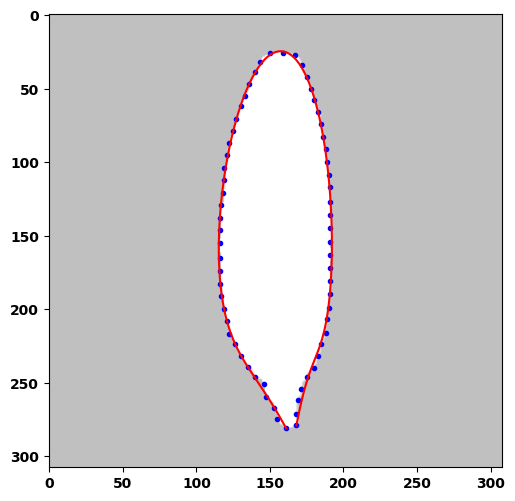

In [38]:
%%time
check1o(7,N=7,err_th=1.0)

...
CP 5.0, steps:2, etime: 2.42188 err: 3.5509357039
..
CP 2.0, steps:4, etime: 3.82812 err: 1.8833180863
...............................................................................................
............................................................
CP 1.0, steps:159, etime: 110.95312 err: 0.9995927561
........................................
...................................................................................^................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...................................

(0.7081388434868623, 1552.8125, 2251)

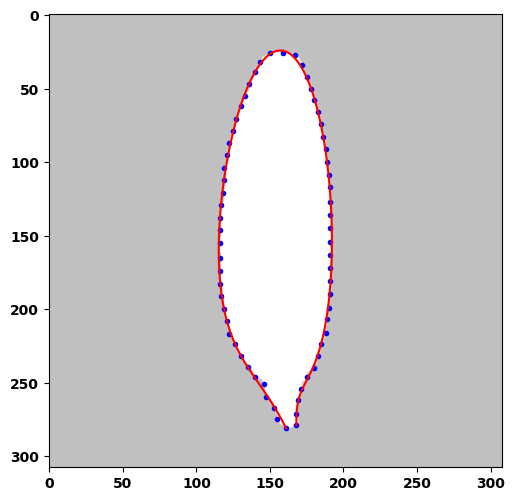

In [39]:
%%time
check1o(7,N=6,err_th=0.5)

....................................................................................................
............................................................................
CP 5.0, steps:175, etime: 100.20312 err: 4.9951380637
........................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.......................................................................^............................
....................................

(2.396946324819263, 1651.359375, 3000)

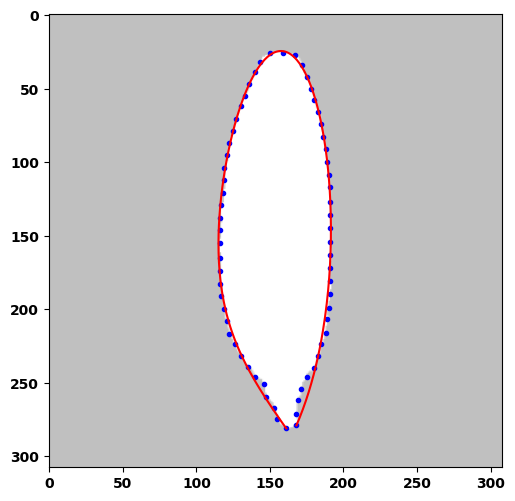

In [40]:
%%time
check1o(7,N=5,err_th=0.5)

..
CP 5.0, steps:1, etime: 3.35938 err: 4.8483622978
........................................................................
CP 2.0, steps:73, etime: 97.23438 err: 1.9925564611
..........................
....................................................................................................
....................................................................................................
....................................................................................................
............................................................................E

Matrix([[159.0*t**9 + 158.38337839626*t**8*(9 - 9*t) - 362.090753591047*t**7*(1 - t)**2 + 42819.3048010558*t**6*(1 - t)**3 - 80746.1935622087*t**5*(1 - t)**4 + 131774.198203854*t**4*(1 - t)**5 - 29214.4380977169*t**3*(1 - t)**6 + 14007.5923251797*t**2*(1 - t)**7 + 1113.07725187204*t*(1 - t)**8 + 166.0*(1 - t)**9], [280.0*t**9 + 207.230833364936*t**8*(9 - 9*t) + 4845.83656773008*t**7*(1 - t)**2 + 31987.79510559

(0.9999157205885655, 625.859375, 475)

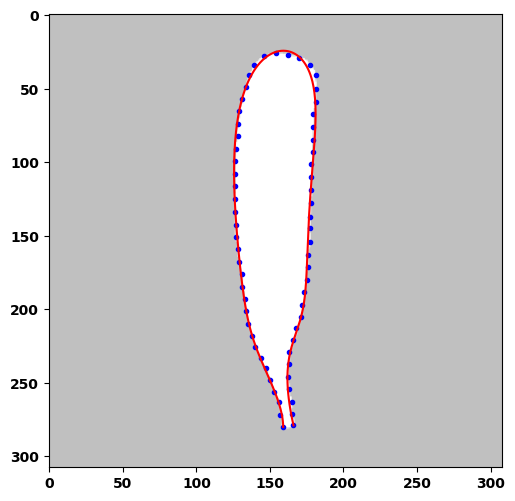

In [41]:
%%time
check1o(8,N=9,err_th=1.0)

...............
CP 5.0, steps:14, etime: 16.75000 err: 4.9699649810
.....................................................................................
...
CP 2.0, steps:102, etime: 110.39062 err: 1.9982536751
.................................................^^^^^^^^^...^^^^^^.^......^^^^^^^^..........^^^.
..........^^..............^.............^.............^...........^...........................^.....
..^^......^.............^.......^.......^.....................^.......^.......^.......^^^...........
....^.......^.....^.......^.....^.....^...^...^.....^^..........^.........^...^...........^.........
..^.....^.....^.....................................................................................
..............................
CP 1.0, steps:629, etime: 673.26562 err: 0.9986695641
......................................................................
....................................................................................................
.............................

(0.6931425028155056, 3244.765625, 3000)

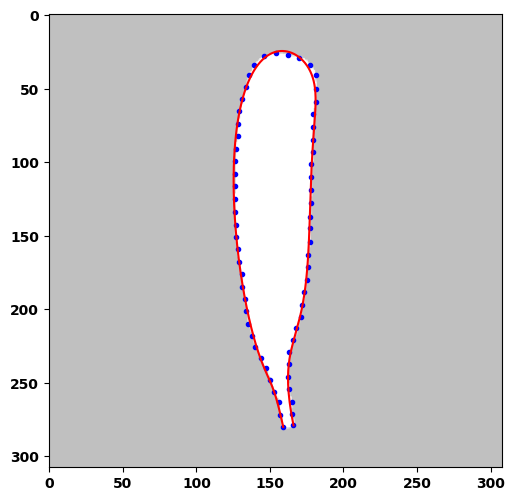

In [42]:
%%time
check1o(8,N=8,err_th=0.5)

....................................................................................................
....................................................................................................
....................................................................................................
..........C

Wall time: 6min 36s


(5.609614169249662,
 396.390625,
 310,
 [[147.0, 280.0],
  [136.51799610442077, 190.22852969409286],
  [184.70361916381455, -40.24063609746817],
  [267.11275156069024, 718.3359080019474],
  [-1046.065526682117, -592.6088504009036],
  [1344.6802338193797, -62.04360914786346],
  [25.50350513925605, 316.6287817966912],
  [134.9173693249074, 127.52666183369149],
  [197.37455274161746, 158.49502084370607],
  [154.0, 280.0]])

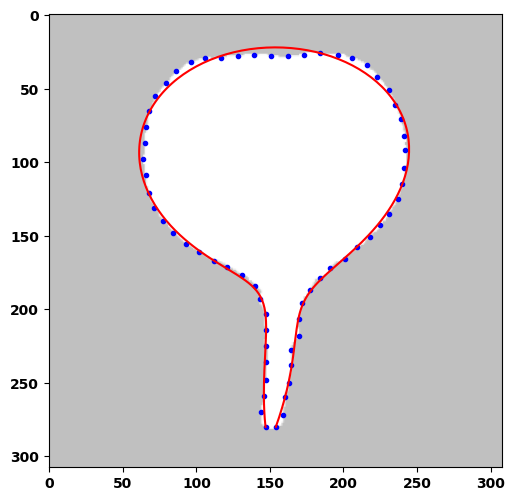

In [4]:
%%time
check1o(1,N=9,err_th=1)

....
CP 5.0, steps:3, etime: 8.39062 err: 4.7818256999
................................................................................................
.............................
CP 2.0, steps:128, etime: 234.67188 err: 1.9950487963
..........................^............................................
....................................................................................................
...............E

Wall time: 9min 36s


(0.9994612544838893,
 575.953125,
 315,
 [[147.0, 280.0],
  [115.26603563521644, 260.9582313135283],
  [409.62212365302776, -519.4125136398757],
  [-812.9050243168105, 2024.0132700713866],
  [1245.9146031025894, -2865.8170869553996],
  [-1233.1376639732105, 2346.342017504177],
  [1242.218794525196, -615.7785197228188],
  [-361.7933661689427, -858.255808866638],
  [703.8399151898954, 1134.9447929894584],
  [27.960172018016266, -290.63126262889136],
  [200.56151181772734, 244.48166417950821],
  [154.0, 280.0]])

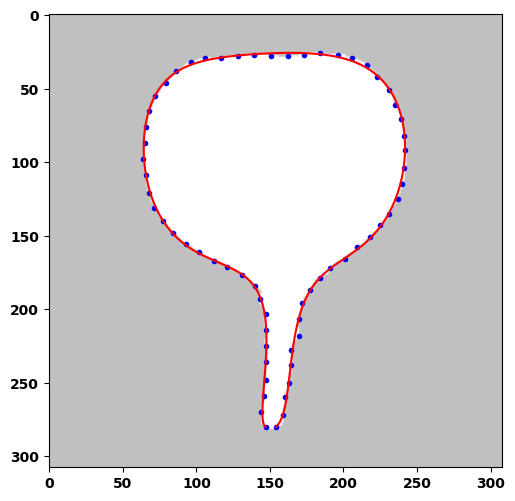

In [5]:
%%time
check1o(1,N=11,err_th=1)

.......
CP 5.0, steps:6, etime: 8.56250 err: 4.6434441746
.........................
CP 2.0, steps:31, etime: 36.03125 err: 1.9916567540
..................................................^^^^^^^^^^...^....
.......^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^..........................
.................................................^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^
.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^
.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^
.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^^.^.^.^^.^.^..^.^.^..^.^.^..^...^^.^.^.^.^.^.^.^.^.^.^
.^.^..^....^....^....^.^^....^.^^....^.^^..^.^^..^.^^..^.....^^..^...^...^...^...^...^...^...^...^..
.^...^...^^^..^^...^^...^^....^^....^^......^^......^^......^^.......^^........^^.........^.........
.^......................................................................................

(0.9998782473405767,
 1848.453125,
 1722,
 [[171.0, 277.0],
  [187.0372019297925, 218.74903522123017],
  [-70.48645619232441, -120.83555947378397],
  [654.8372439948871, 429.1777404638114],
  [-195.52354578472537, -579.5226528391289],
  [308.34021542940934, 370.8977255668404],
  [27.71022560577466, 69.54987499847319],
  [122.91418780886227, 196.96758824578995],
  [167.0, 281.0]])

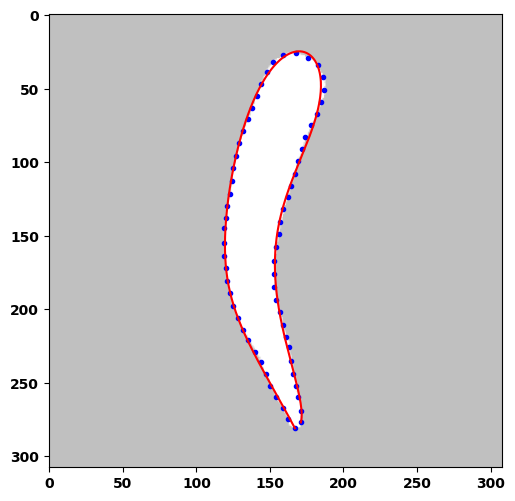

In [6]:
%%time
check1o(2,N=8,err_th=1)

..
CP 5.0, steps:1, etime: 3.40625 err: 4.7259154669
.........
CP 2.0, steps:10, etime: 15.64062 err: 1.9508256061
.........................................................................................
..................................................................E

Wall time: 3min 46s


(0.9999698974352016,
 226.609375,
 166,
 [[171.0, 277.0],
  [159.84827050722473, 197.22280927147136],
  [225.81601677983798, 344.5752553983434],
  [-263.8980067785642, -512.5370598011106],
  [1022.8841750513086, 1154.5444466032525],
  [-490.65148812402794, -1584.7759967955535],
  [364.94488950348216, 1169.5288144072613],
  [33.02630017807883, -147.85353444699666],
  [140.72540839344614, 262.42405800710833],
  [167.0, 281.0]])

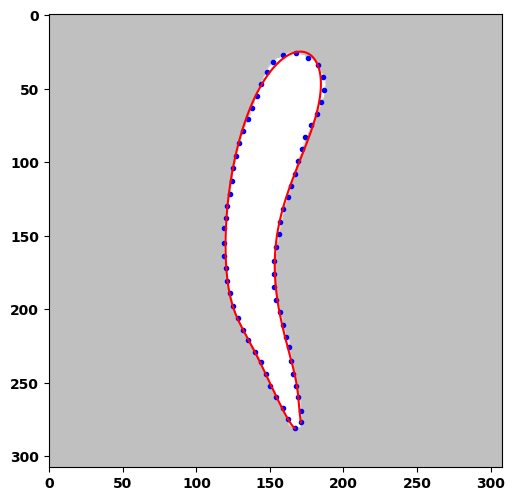

In [7]:
%%time
check1o(2,N=9,err_th=1)

....................................................................................................
....................................................................................................
....................................................................................................
..............................
CP 5.0, steps:329, etime: 181.46875 err: 4.9901608745
......................................................................
....................................................................................................
....................................................................................................
......
CP 2.0, steps:605, etime: 329.76562 err: 1.9989563123
..............................................................................................
....................................................................................................
..................................................................................

(1.4631625689478702,
 881.796875,
 1622,
 [[161.0, 279.0],
  [170.1129501305067, -113.93262339899388],
  [276.8508904063824, 229.6234372331575],
  [29.078714505685845, -261.7982831615734],
  [128.4788331311016, 220.1814398401764],
  [154.0, 280.0]])

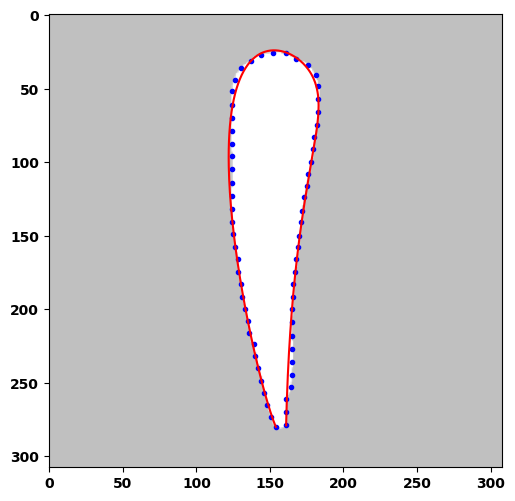

In [8]:
%%time
check1o(3,N=5,err_th=1)

...................................................................................................
CP 5.0, steps:98, etime: 73.48438 err: 4.9682247242
.
....................................................................................................
...........................................
CP 2.0, steps:242, etime: 180.64062 err: 1.9946634147
.........................................................
............................................................................................^.......
....................................................................................................
....................^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^^.^.^^.^.^^.^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.
^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^.^^
.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^.^^

(1.1796420832469343,
 962.234375,
 1330,
 [[161.0, 279.0],
  [174.0088284482815, 224.13047492441794],
  [125.22318102282564, -198.0377838900922],
  [364.45897410514175, 386.24132875795294],
  [-15.622581008904955, -397.7338794746053],
  [135.604671254357, 245.53752202343887],
  [154.0, 280.0]])

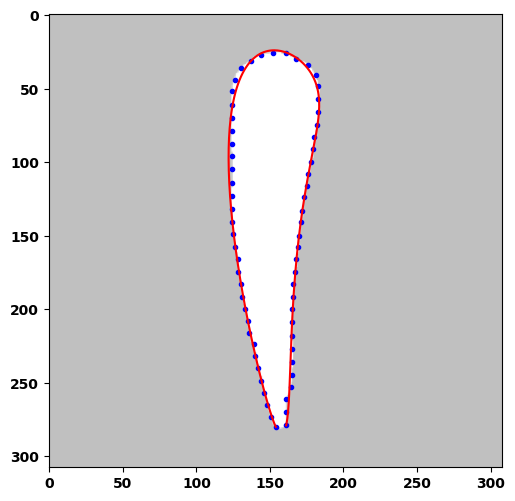

In [9]:
%%time
check1o(3,N=6,err_th=1)

..............................
CP 5.0, steps:29, etime: 26.76562 err: 4.9855785880
......................................................................
....................................................................................................
..................................
CP 2.0, steps:233, etime: 205.25000 err: 1.9985533694
..................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(1.176536493179981,
 2650.46875,
 3001,
 [[161.0, 279.0],
  [179.51027062573212, 217.2933179994837],
  [94.47771002164693, -191.59442406513924],
  [444.0569498119237, 379.56097534230184],
  [-106.21978805781495, -401.6951346335447],
  [187.2561726210144, 216.5904334633312],
  [112.80452785421109, 187.51507623981087],
  [154.0, 280.0]])

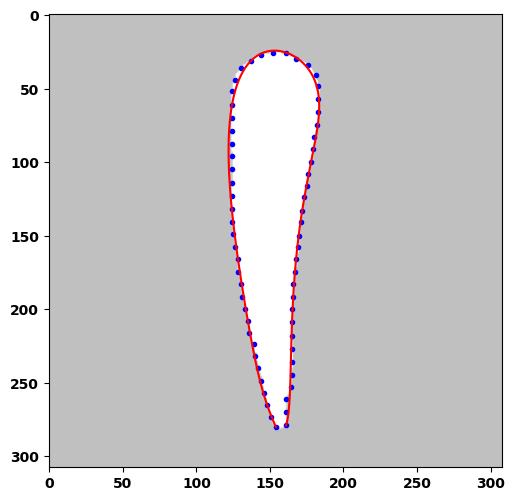

In [10]:
%%time
check1o(3,N=7,err_th=1)

.
CP 5.0, steps:0, etime: 3.46875 err: 4.5721138919
.....
CP 2.0, steps:5, etime: 13.87500 err: 1.9323920179
.............E

Wall time: 41.1 s


(0.9910972706596523,
 41.03125,
 19,
 [[148.0, 279.0],
  [164.00241405785061, 155.86251714553003],
  [26.088483265337466, 906.86732149117],
  [682.3556678367119, -3369.018004363578],
  [-1104.273742441164, 9515.997585026404],
  [1103.7501502889659, -16323.86623278574],
  [-343.3527435156842, 19898.94881241485],
  [38.589553058325826, -17840.70621293765],
  [982.4662478899407, 11406.247246187368],
  [-278.6473333338317, -4506.714892068755],
  [281.56964953877076, 1270.9215159941414],
  [149.6056118147832, 113.1796490314736],
  [154.0, 280.0]])

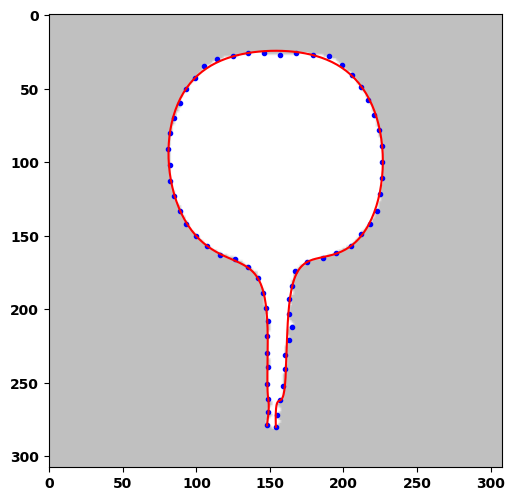

In [11]:
%%time
check1o(4,N=12,err_th=1)

...........
CP 5.0, steps:10, etime: 21.17188 err: 4.9089459791
.........................................................................................
...........................
CP 2.0, steps:126, etime: 232.15625 err: 1.9972432324
.........................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
............................................E

Wall time: 22min 31s


(0.9987621013517469,
 1351.453125,
 744,
 [[148.0, 279.0],
  [146.38094689182398, 258.91874540379365],
  [200.94466301893874, -637.5531396646652],
  [-74.25693885551962, 2506.576541261893],
  [-140.16680530482068, -3980.0086450071526],
  [678.799840164053, 4153.897212870092],
  [-533.8995065693327, -2694.8304833624165],
  [895.5122938678982, 620.8512695129239],
  [47.65834180877058, 679.7767921659782],
  [160.13926308902526, -218.89735957329043],
  [176.06857404604114, 225.0372103138453],
  [154.0, 280.0]])

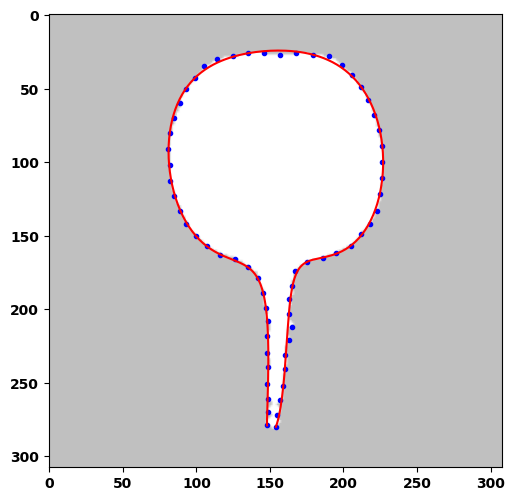

In [12]:
%%time
check1o(4,N=11,err_th=1)

.....................
CP 5.0, steps:20, etime: 33.68750 err: 4.9999594670
...............................................................................
....................................................................................................
..........................................
CP 2.0, steps:241, etime: 380.57812 err: 1.9996166466
..........................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................................^^^^^^^..................................................
....................................................................................................
....................................................................................

(0.9999998977262059,
 3433.09375,
 2187,
 [[138.0, 279.0],
  [222.86446510604003, 93.28642629649025],
  [-756.2677025568354, 961.9369871385102],
  [2225.4914948715905, -2189.346365461991],
  [-3052.696830016685, 3761.4460884900573],
  [3046.124357971804, -4495.725798343834],
  [-1344.1918554005942, 3795.8351364004448],
  [674.9881658598034, -2144.024497243527],
  [178.78113963369884, 1062.9357075830862],
  [258.449918493676, 62.38734352048741],
  [144.0, 281.0]])

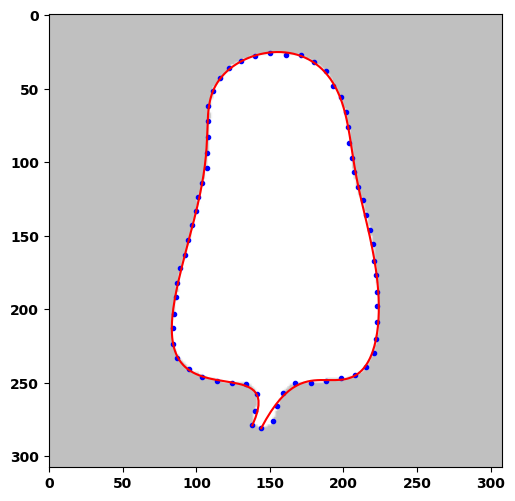

In [13]:
%%time
check1o(6,N=10,err_th=1)

...
CP 5.0, steps:2, etime: 3.06250 err: 2.8873477505
.
CP 2.0, steps:3, etime: 3.92188 err: 1.8986485062
......E

Wall time: 9.09 s


(0.9757345386376545,
 9.078125,
 10,
 [[168.0, 279.0],
  [196.61535148048853, 128.54091900462706],
  [187.23898200306928, 453.3704132440659],
  [265.9803804343957, -423.0000419724393],
  [45.132038186805566, -2.5543573269469997],
  [114.00520987754439, 281.21676255935347],
  [104.81458687742284, 177.60614606994352],
  [161.0, 281.0]])

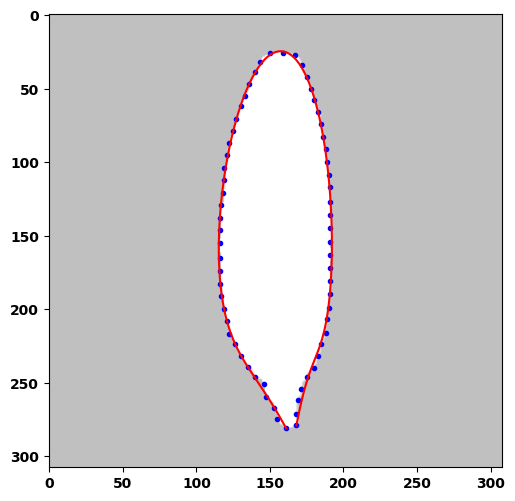

In [14]:
%%time
check1o(7,N=7,err_th=1)

...
CP 5.0, steps:2, etime: 3.04688 err: 2.8873477505
.
CP 2.0, steps:3, etime: 3.89062 err: 1.8986485062
......
CP 1.0, steps:9, etime: 8.95312 err: 0.9757345386
..........................................................................................
..........................................................^^........................................
....................................................................................................
...................^^^^^^^^^^^^^^^^^^^^^^^^^^^^........................^^^^^^^......................
....................................................................................................
....................................................................................................
...................................................................................................^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.6897143769970541,
 2555.15625,
 3001,
 [[168.0, 279.0],
  [168.8801689146552, 172.6004036294857],
  [245.28105365592202, 442.6805456239011],
  [200.49239993554136, -502.84486263403426],
  [81.6181885709272, 100.51611439041112],
  [98.13738059591785, 237.28995214382397],
  [110.4229306144768, 189.66731411687337],
  [161.0, 281.0]])

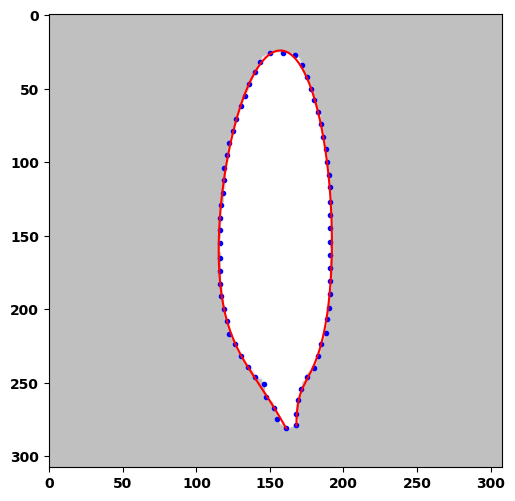

In [15]:
%%time
check1o(7,N=7,err_th=0.5)

.......
CP 5.0, steps:6, etime: 8.42188 err: 4.6434441746
.........................
CP 2.0, steps:31, etime: 35.14062 err: 1.9916567540
..................................................^^^^^^^^^^...^....
.......^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^..........................
.................................................^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^
.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^
.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^
.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^.^^.^.^.^^.^.^..^.^.^..^.^.^..^...^^.^.^.^.^.^.^.^.^.^.^
.^.^..^....^....^....^.^^....^.^^....^.^^..^.^^..^.^^..^.....^^..^...^...^...^...^...^...^...^...^..
.^...^...^^^..^^...^^...^^....^^....^^......^^......^^......^^.......^^........^^.........^.........
.^......................................................................................

(0.9158429469224321,
 2976.125,
 2717,
 [[171.0, 277.0],
  [185.3494857741882, 212.11743881710788],
  [-79.2987530394152, -129.4451400363062],
  [714.2771162415727, 438.7404541482562],
  [-299.84262726156004, -629.8481482202429],
  [390.30826893511835, 464.59010216154724],
  [-12.036995633828036, 6.098113628203654],
  [133.9925870902402, 217.0741452691248],
  [167.0, 281.0]])

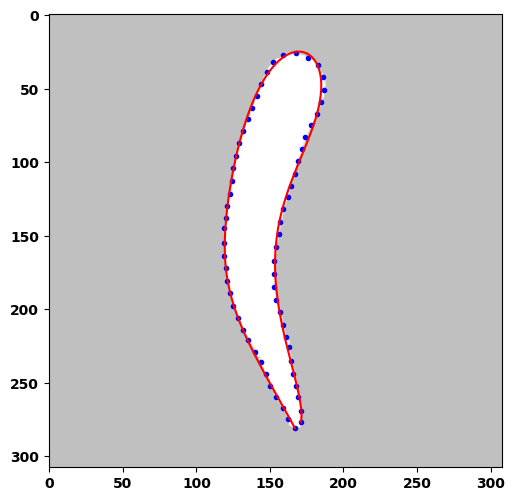

In [18]:
%%time
check1o(2,N=8,err_th=0.5)

....
CP 5.0, steps:3, etime: 8.50000 err: 4.7818256999
................................................................................................
.............................
CP 2.0, steps:128, etime: 235.04688 err: 1.9950487963
..........................^............................................
....................................................................................................
...............
CP 1.0, steps:314, etime: 574.32812 err: 0.9994612545
.....................................................................................
....................................................................................................
.....
CP 0.65, steps:504, etime: 923.73438 err: 0.6497354429
...............................................................................................
.................................^^..........^^^......^^.....^^....^^....^^^....^^^....^^^...^^^...^
^^^...^^^^..^^^^..^^^^..^^^^^..^^^^^^^^^^...................................

(0.5373099280833918,
 5556.828125,
 3001,
 [[147.0, 280.0],
  [115.77524925406438, 242.87829227177514],
  [389.6626261689577, -319.32019241859143],
  [-656.5701555718498, 1235.7407045268585],
  [874.358526682533, -953.1009804014442],
  [-814.5595114418159, -660.4569812473296],
  [1162.9441491295456, 2512.172785823137],
  [-741.8914884697975, -2888.682916416536],
  [1018.4999413076648, 1812.9991361666087],
  [-34.43060250224336, -409.6811627253514],
  [209.0985003953879, 231.06263948114662],
  [154.0, 280.0]])

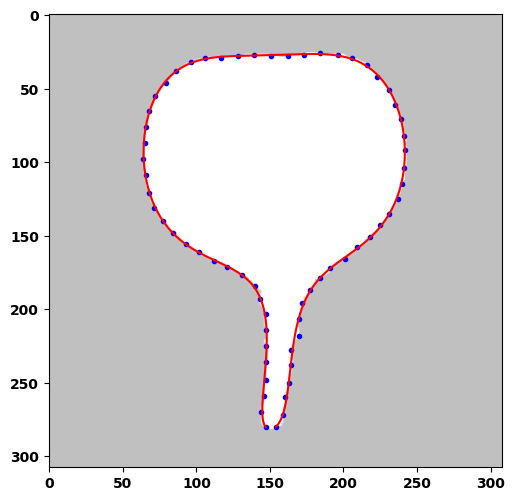

In [20]:
%%time
check1o(1,N=11,err_th=0.5)

.
CP 5.0, steps:0, etime: 3.53125 err: 2.4605386886
.
CP 2.0, steps:1, etime: 5.62500 err: 1.9752127686
...........................................^........
CP 1.0, steps:53, etime: 113.96875 err: 0.9974503167
..............................................
....................................................................................................
......................................................................^.......^.......^.......^.....
.^........^.........^...............................................
CP 0.65, steps:367, etime: 773.70312 err: 0.6497224042
................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................^.^.^.^.^..............................

(0.5241148234608484,
 2794.828125,
 1326,
 [[147.0, 280.0],
  [124.68991925112658, 218.10086346712313],
  [243.5239441943258, 355.6679152138447],
  [78.50884480908327, -1543.8966501532732],
  [-321.96669566596796, 5703.328296437475],
  [101.52215977192297, -10619.017813780174],
  [931.0976489158397, 12643.678507329378],
  [-1107.8437577025466, -9940.264723838007],
  [1321.4860932902127, 4952.8195925000655],
  [-29.16708795957648, -1223.1080283003375],
  [168.4112102409796, 275.42107587611656],
  [180.27526040679015, 231.42694908559488],
  [154.0, 280.0]])

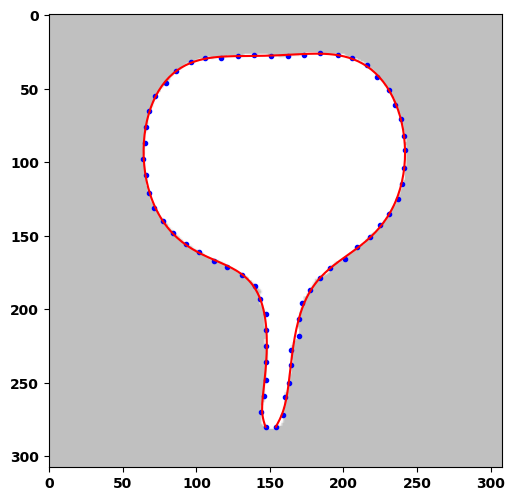

In [21]:
%%time
check1o(1,N=12,err_th=0.5)

..
CP 5.0, steps:1, etime: 3.35938 err: 4.7259154669
.........
CP 2.0, steps:10, etime: 15.26562 err: 1.9508256061
.........................................................................................
..................................................................
CP 1.0, steps:165, etime: 217.10938 err: 0.9999698974
..................................
....................................................................................................
....................................................................................................
....................................................^^^^^^^^....................^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^............................
....................................................................................................
........................................................................................^^.^^..^^..^
^...^....^^......................

(0.8229268499580742,
 3974.03125,
 3001,
 [[171.0, 277.0],
  [164.71736215939708, 186.1014305462338],
  [180.44087989948196, 358.7748217153526],
  [-138.85800532165385, -568.7949984626894],
  [867.7331699308635, 1138.6379912060488],
  [-423.47172682482534, -1370.6221986968321],
  [433.87693276290304, 922.3864686361823],
  [-28.988481693125504, -126.90412744222974],
  [143.23266946005901, 247.0385835238575],
  [167.0, 281.0]])

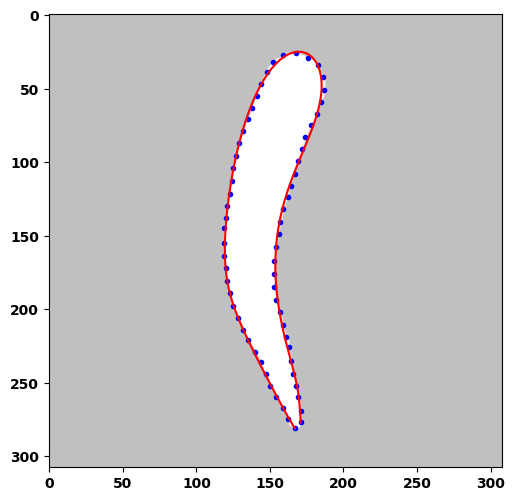

In [22]:
%%time
check1o(2,N=9,err_th=0.5)

..
CP 5.0, steps:1, etime: 4.12500 err: 4.7032148865
.............
CP 2.0, steps:14, etime: 24.35938 err: 1.9459221557
.....................................................................................
...
CP 1.0, steps:102, etime: 160.35938 err: 0.9986826579
.................................................................................................
........................................^.......^........^.......^^......^^.......^^......^^......^^
.......^^......^^.......^^.......^^.......^^.......^^........^^........^^........^^.........^^......
...^^..........^^..........^^....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^......................................
...................................^^.................................................^...........^.
..........^..........^..........^.......^......^......^......^.......^......^......^.......^......^.
.....^.....^^^^^.^.^.^.^.^.^.^^^^^^^^^^^^^^^^^^.....................................................
...................
CP 0.65, step

(0.5315480146997138,
 4725.515625,
 3001,
 [[171.0, 277.0],
  [157.23009534647724, 185.3275400230403],
  [228.971377669098, 293.7724083121545],
  [-348.0214612676483, -289.83870477616307],
  [1393.394129427246, 442.31901146675943],
  [-1183.0160494584545, -411.1859986181119],
  [1108.1319016860798, 147.6975768254792],
  [-357.29080357552374, 144.34376027359434],
  [220.54784000693732, 150.06369989212237],
  [123.74875487447984, 237.3146005046526],
  [167.0, 281.0]])

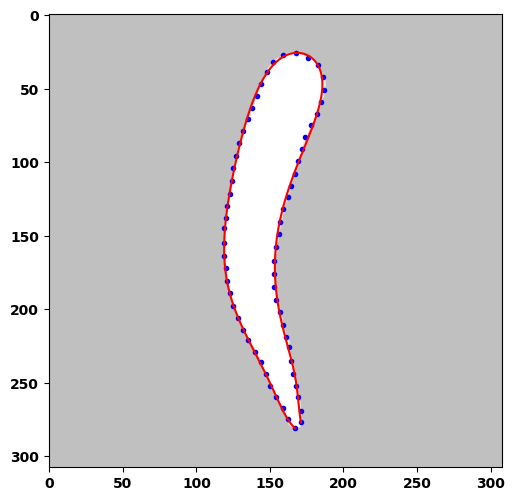

In [23]:
%%time
check1o(2,N=10,err_th=0.5)

....................................................................................................
..................
CP 5.0, steps:117, etime: 129.70312 err: 4.9618457601
................................................
CP 2.0, steps:165, etime: 182.51562 err: 1.9714127767
..................................
...........
CP 1.0, steps:210, etime: 231.45312 err: 0.9887271581
.............................................................
CP 0.65, steps:271, etime: 297.51562 err: 0.6497802686
............................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
........................................................................

(0.5164304268805473,
 3329.84375,
 3001,
 [[149.0, 279.0],
  [-40.32888281663506, 259.9737230613564],
  [194.2612393043208, -11.328197280181366],
  [452.8825523880623, 186.21902635529182],
  [-890.5572713936303, -162.76269970381685],
  [1410.5545327430552, 94.52316770102063],
  [-585.1990927323704, -29.913454511844574],
  [490.592717488723, 200.75715325333712],
  [156.0, 281.0]])

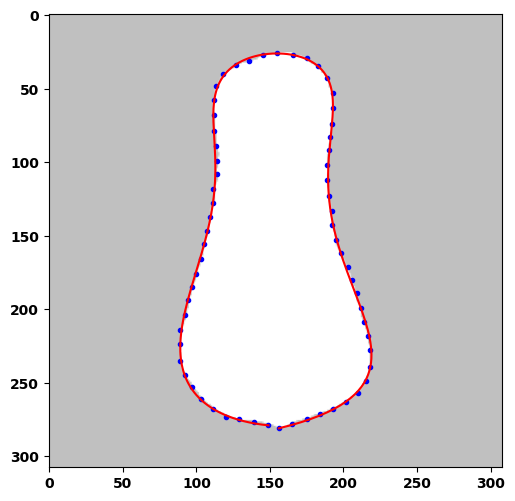

In [24]:
%%time
check1o(0,N=8,err_th=0.5)

...........................
CP 5.0, steps:26, etime: 37.48438 err: 4.9780349359
..................................................
CP 2.0, steps:76, etime: 104.62500 err: 1.9964342261
.......................
...........................
CP 1.0, steps:126, etime: 172.07812 err: 0.9990103228
...^.....................................................................
..
CP 0.65, steps:201, etime: 273.00000 err: 0.6485708816
..................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...............................................................................^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(0.5069294413362139,
 1292.625,
 980,
 [[149.0, 279.0],
  [83.53004615664298, 282.0703402622738],
  [-322.09101895220084, 89.68683797716194],
  [1586.0726279045273, 43.612605620349534],
  [-2512.2771185560587, -41.79195296289981],
  [2913.4054612570403, 26.817224029816927],
  [-1435.2495221978884, -36.90912642450601],
  [700.8902800331115, 169.74818727522745],
  [210.89548311109996, 263.86486457556356],
  [156.0, 281.0]])

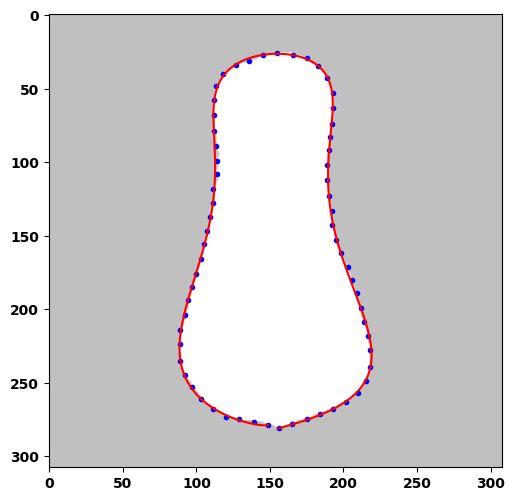

In [25]:
%%time
check1o(0,N=9,err_th=0.5)

.
CP 5.0, steps:0, etime: 3.50000 err: 4.5721138919
.....
CP 2.0, steps:5, etime: 13.98438 err: 1.9323920179
.............
CP 1.0, steps:18, etime: 41.21875 err: 0.9910972707
.................................................................................
^......^^...^.........................^^.^.^.^.............^..^^..^^..^^............................
....................................................................................................
................................................................................................^^^^
...........^^^^^^^.......^^^^^^^^^.....^^^^^^^^^^...^^^^^^^^^^..^^^^^^^^^^..^^^^^^^^^^..^^^^^^^^^^..
^^^^^^^^^..^^^^^^^^^..^^^^^^^^^..^^^^^^^^..^^^^^^^^..^^^^^^^^..^^^^^^^^..^^^^^^^^..^^^^^^^^^.^^^^^^^
^^.^^^^^^^^.^^^^^^^^.^^^^^^^^.^^^^^^^^.^^^^^^^^.^^^^^^^^.^^^^^^^^.^^^^^^^^.^^^^^^^^.^^^^^^^^.^^^^^^^
.^^^^^^^^.^^^^^^^.^^^^^^^^.^^^^^^^^^^^^^^^..^^^^.^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^.^^.^^.^^.^.^^.^^.^^.^^.^

(0.6842430076410723,
 5040.53125,
 2378,
 [[148.0, 279.0],
  [162.1860315499063, 198.88608068340795],
  [21.467711760974737, 397.86865875939117],
  [837.6098392320717, -1847.9136086016658],
  [-1999.6586309221066, 7088.978570326864],
  [2866.0155233107193, -14588.727808388834],
  [-2032.4119001848849, 20036.09128732151],
  [938.6566802251831, -19361.750512363007],
  [752.1718481905909, 13018.43896491824],
  [-298.4000717026278, -5469.3750260696825],
  [315.10076246274406, 1614.5746958856441],
  [138.6953952109939, 63.698698563163134],
  [154.0, 280.0]])

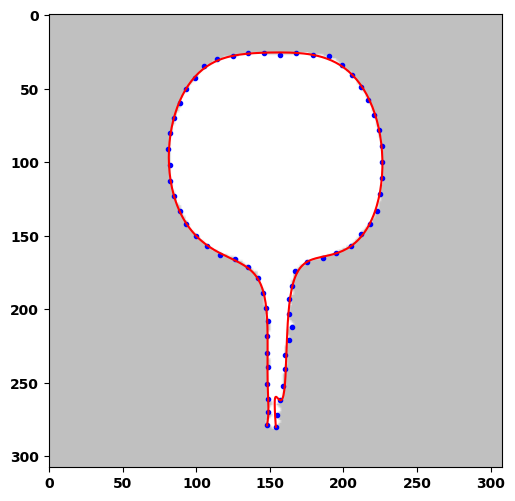

In [26]:
%%time
check1o(4,N=12,err_th=0.5)

............
CP 5.0, steps:11, etime: 19.82812 err: 4.9311877759
............................................................................^^..........
...............................^....................................................................
....................................................................................................
......................................
CP 2.0, steps:337, etime: 537.39062 err: 1.9990344124
..............................................................
.......^^^^.....^^^^^^...^^^........................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................

(0.8724085454806223,
 4140.5625,
 2622,
 [[148.0, 279.0],
  [142.4236358336205, 230.17369887101665],
  [246.9457017069178, -574.210542981171],
  [-320.0038581379413, 2538.8333591893233],
  [317.4649074184619, -4588.366831061701],
  [224.6332574649079, 5556.198244770312],
  [-132.66197015930294, -4688.121702672056],
  [714.4869998490497, 2627.1777791195877],
  [5.609231394120317, -567.4913977115856],
  [196.12406421200942, 201.77620834512328],
  [154.0, 280.0]])

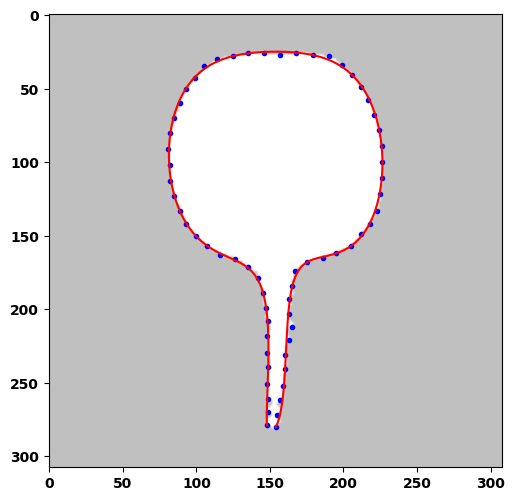

In [27]:
%%time
check1o(4,N=10,err_th=0.5)

.
CP 5.0, steps:0, etime: 2.14062 err: 4.8650188268
..
CP 2.0, steps:2, etime: 4.84375 err: 1.5394200383
...
CP 1.0, steps:5, etime: 8.89062 err: 0.9425557260
..............................................................................................
............................
CP 0.65, steps:127, etime: 174.06250 err: 0.6498222889
........................................................................
....................................................................................................
.............................................................C

Wall time: 8min 6s


(0.6330243009908436,
 486.015625,
 361,
 [[168.0, 279.0],
  [154.46021857265924, 209.08196897311294],
  [344.94735863699447, 207.2271215717756],
  [-130.92950118042413, 90.47957360343017],
  [691.2261260099315, 84.80703293329334],
  [-334.06329424350935, -498.71618329249105],
  [359.91073352469044, 510.1513406374307],
  [7.1974528834884275, 70.15021571887554],
  [133.4205254198166, 230.45412768029803],
  [161.0, 281.0]])

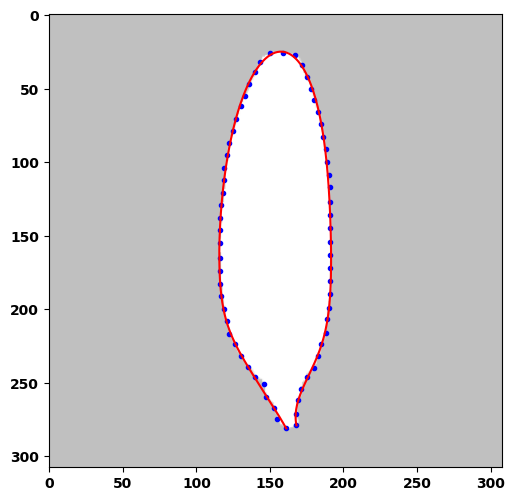

In [28]:
%%time
check1o(7,N=9,err_th=0.5)

..
CP 5.0, steps:1, etime: 4.06250 err: 4.8630138780
...............................
CP 2.0, steps:32, etime: 52.32812 err: 1.9828952736
...................................................................
......................................
CP 1.0, steps:137, etime: 215.87500 err: 0.9977941569
..............................................................
....................................................................................................
....................................................................................................
...........
CP 0.65, steps:410, etime: 640.90625 err: 0.6495686275
.........................................................................................
....................................................................................................
....................................................................................................
..............................................................................

(0.5048529708074242,
 2612.46875,
 1659,
 [[166.0, 279.0],
  [162.13161587044155, 220.50035583023714],
  [82.73654770866183, 74.83326185224772],
  [634.8273916039027, 609.7043668478202],
  [-881.7050890683519, -1220.3855711668252],
  [1718.6561916457993, 1872.0414483648308],
  [-1146.8968577303037, -1834.5036227536525],
  [747.6663956936094, 1019.168642677165],
  [-78.06040926976745, -58.63645062514096],
  [166.7830681597312, 232.46925621305002],
  [159.0, 280.0]])

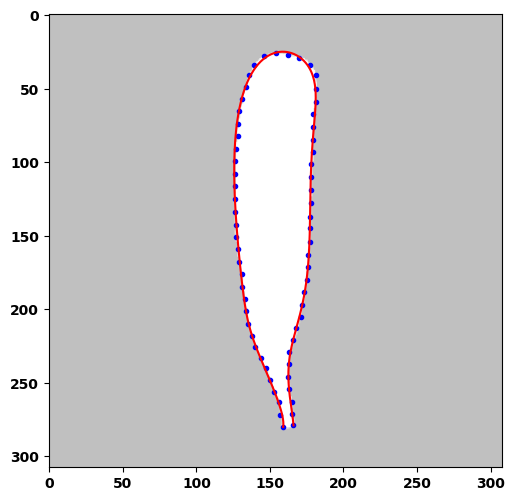

In [29]:
%%time
check1o(8,N=10,err_th=0.5)

.
CP 5.0, steps:0, etime: 3.96875 err: 3.0021573864
........
CP 2.0, steps:8, etime: 22.79688 err: 1.9754400607
.......................................................................
CP 1.0, steps:79, etime: 189.56250 err: 0.9991117742
....................
................................................................^...............................^^^^
^^.....^^^^^^^^^^^^^^....................
CP 0.65, steps:240, etime: 567.23438 err: 0.6488743673
.....................^.....^.....^.....^......^^....^^...^^
.....^^....^^^..^^^..^^^..^^^..^^^..^^^..^^^...^^^^...^^^^...^^^^...^^^^...^^^^...^^^^...^^^^...^^^.
.^^^...^^^^...^^^...^^^^...^^^...^^^^...^^^...^^^...^^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^.
.^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^^..^^^
^..^^^^..^^^^...^^^^..^^^^..^^^^...^^^^..^^^^^..^^^^..^^^^^..^^^^^.^^^^^..^^^^^.^^^..^^^^^..^^^^^..^
^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^^..^^^^

(0.5638605363400132,
 5994.953125,
 2542,
 [[138.0, 279.0],
  [154.03888615519466, 228.80008653726745],
  [155.97322236605004, 49.775048702559566],
  [-370.0253941944858, 1379.9680730703158],
  [183.66552476598716, -2718.0611522436784],
  [2292.538823242608, 3608.2702452018184],
  [-5128.1731710443455, -2466.1804980296697],
  [6189.309671517145, -126.5485889688312],
  [-3557.4280536072165, 2199.7133423083733],
  [1286.3784107470085, -2472.1414571258956],
  [388.9556208148534, 1756.5123807233729],
  [71.66701935684597, -184.86347098967485],
  [192.3359715739097, 285.02050328835816],
  [144.0, 281.0]])

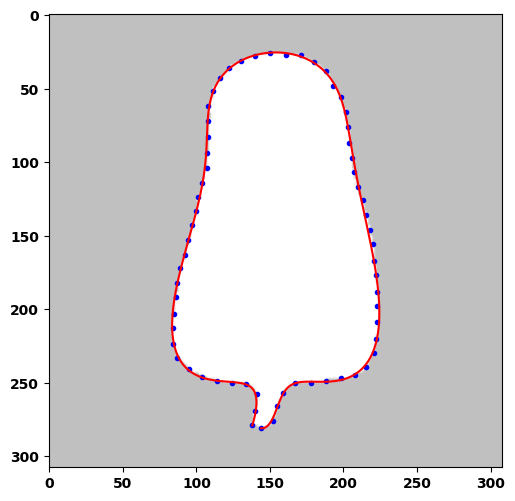

In [4]:
%%time
check1o(6,N=13,err_th=0.5)